In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [2]:
from events_data import events_from_scdinfo
from tst_info import TSTInfo
from debiasing import get_bias_fn, get_histograms
from plots import hist_events_by_labels
import tqdm

def draw_routine(hashes, rw_methods=["CR"], debias_list=[False, True], calibration_nbin=20):
    device = torch.device("cuda")
    for tstinfo_hash in tqdm.tqdm(hashes):
        tstinfo = TSTInfo.load(tstinfo_hash)
        signal_filename = tstinfo.hparams["signal_filename"]
        seed = tstinfo.hparams["seed"]
        signal_ratio = tstinfo.hparams["signal_ratio"]

        scdinfo_tst = tstinfo.scdinfo_tst
        events_tst = events_from_scdinfo(
            scdinfo_tst, features, signal_filename)

        base_fvt_hash = tstinfo.base_fvt_tinfo_hash
        fvt_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
        fvt_model.to(device)
        fvt_model.freeze()

        CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
        CR_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
        CR_model.to(device)
        CR_model.freeze()

        SR_stats = tstinfo.SR_stats
        SR_cut = tstinfo.SR_cut
        CR_cut = tstinfo.CR_cut
        in_SR = SR_stats >= SR_cut
        in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

        ratio_4b = tstinfo.hparams["ratio_4b"]

        for rw_method in rw_methods:
            if rw_method == "CR":
                probs_4b_est = CR_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]
            else:
                probs_4b_est = fvt_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]

            reweights = ratio_4b * probs_4b_est / \
                ((1 - ratio_4b) * (1 - probs_4b_est))
        
            for debias in debias_list:
                if debias:
                    bias_fn = get_bias_fn(events_tst, probs_4b_est, calibration_nbin)
                    bias_3b_rw = bias_fn(probs_4b_est)
                else:
                    bias_3b_rw = np.zeros_like(probs_4b_est)

                events_SR = events_tst[in_SR]
                events_CR = events_tst[in_CR]
                SR_stats_SR = SR_stats[in_SR]
                SR_stats_CR = SR_stats[in_CR]

                events_tst_rw = events_tst.clone()
                # include bias
                events_tst_rw.reweight(
                    np.where(events_tst_rw.is_4b, events_tst_rw.weights, events_tst_rw.weights * (reweights - bias_3b_rw)))
                events_SR_rw = events_tst_rw[in_SR]
                events_CR_rw = events_tst_rw[in_CR]

                fig = plt.figure(figsize=(12, 8))
                fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}, reweighting={rw_method}, debias={debias}")
                gs = GridSpec(3, 2, figure=fig)

                # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), 10)
                q = np.linspace(0, 1, 10)
                bins = np.quantile(SR_stats_CR, q)

                ax = fig.add_subplot(gs[0, 0])
                hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("CR")
                ax.legend()

                histograms = get_histograms(
                    events_CR, SR_stats_CR, bins, reweights[in_CR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_bg4b = histograms["bg4b"]
                hist_4b = histograms["4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins,
                                                    weights=(events_CR.weights * bias_3b_rw[in_CR])[events_CR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                q = np.linspace(0, 1, 10)
                bins = np.quantile(SR_stats_SR, q)

                ax = fig.add_subplot(gs[0, 1])
                hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("SR")
                ax.legend()

                histograms = get_histograms(
                    events_SR, SR_stats_SR, bins, reweights[in_SR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_4b = histograms["4b"]
                hist_bg4b = histograms["bg4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_SR[events_SR.is_3b], bins=bins,
                                                    weights=(events_SR.weights * bias_3b_rw[in_SR])[events_SR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                plt.tight_layout()
                plt.show()

In [3]:
def get_sigma_avg(events: EventsData, hist_values: np.ndarray, bins, reweights: np.ndarray):
    hist_3b, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=events.weights[events.is_3b])
    hist_4b, _ = np.histogram(hist_values[events.is_4b], bins=bins, 
                                weights=events.weights[events.is_4b])
    hist_3b_sq, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=(events.weights * reweights)[events.is_3b])
    sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    return sigma_avg

def plot_reweighted_samples(events_reweighted: EventsData, 
                            events_not_reweighted: EventsData,
                            hist_values: np.ndarray, 
                            fig: plt.Figure):
    gs = GridSpec(2, 2, figure=fig)
    for ax_cnt, quantile in enumerate([True, False]):
        if quantile:
            q = np.linspace(0, 1, 10)
            bins = np.quantile(hist_values, q)
        else:
            bins = np.linspace(np.min(hist_values), np.max(hist_values), 10)

        ax = fig.add_subplot(gs[ax_cnt, 0])
        hist_events_by_labels(events_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("Reweighted")
        ax.legend()
        ax = fig.add_subplot(gs[ax_cnt, 1])
        hist_events_by_labels(events_not_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("NOT Reweighted")
        ax.legend()

In [4]:
from dataset import generate_mother_dataset
import pytorch_lightning as pl

dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 10,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5
SR_train_ratio = 0.25

n_3b = 200_000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")

train_seeds = [0]
nbins = range(1, 11)
uniform_weights_list = [False]


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)

# Remove 4b events
df_all = df_all.iloc[:n_3b]
# give random "fourTag" labels
np.random.seed(data_seed)
df_all["fourTag"] = np.random.choice([0, 1], size=n_3b, p=[1 - ratio_4b, ratio_4b])
df_all["signal"] = False
df_all_uniform_weights = df_all.copy()
df_all_uniform_weights["weight"] = 1

sigma_dicts = []
probs_4b_ests = []
SR_stats = []

for train_seed in train_seeds:
    for uniform_weights in uniform_weights_list:
        
        if uniform_weights:
            events_all = EventsData.from_dataframe(df_all_uniform_weights, features)
        else:
            events_all = EventsData.from_dataframe(df_all, features)
            
        events_train, events_other = events_all.split(base_fvt_train_ratio, seed=data_seed)
        
        pl.seed_everything(train_seed)
        np.random.seed(train_seed)
        
        base_fvt_hparams["train_seed"] = train_seed
        
        events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        base_fvt_train_dset = events_train.to_tensor_dataset()
        base_fvt_val_dset = events_val.to_tensor_dataset()
        
        base_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )

        base_fvt_model.fit(
            base_fvt_train_dset,
            base_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False, 
            callbacks=[],
        )
        base_fvt_model.to(device)
        base_fvt_model.eval()
        
        
        probs_4b_est = base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1]

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Par

Epoch 9: 100%|██████████| 65/65 [00:05<00:00, 12.37it/s, v_num=188, val_loss=0.693, train_loss=0.693]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:05<00:00, 12.29it/s, v_num=188, val_loss=0.693, train_loss=0.693]


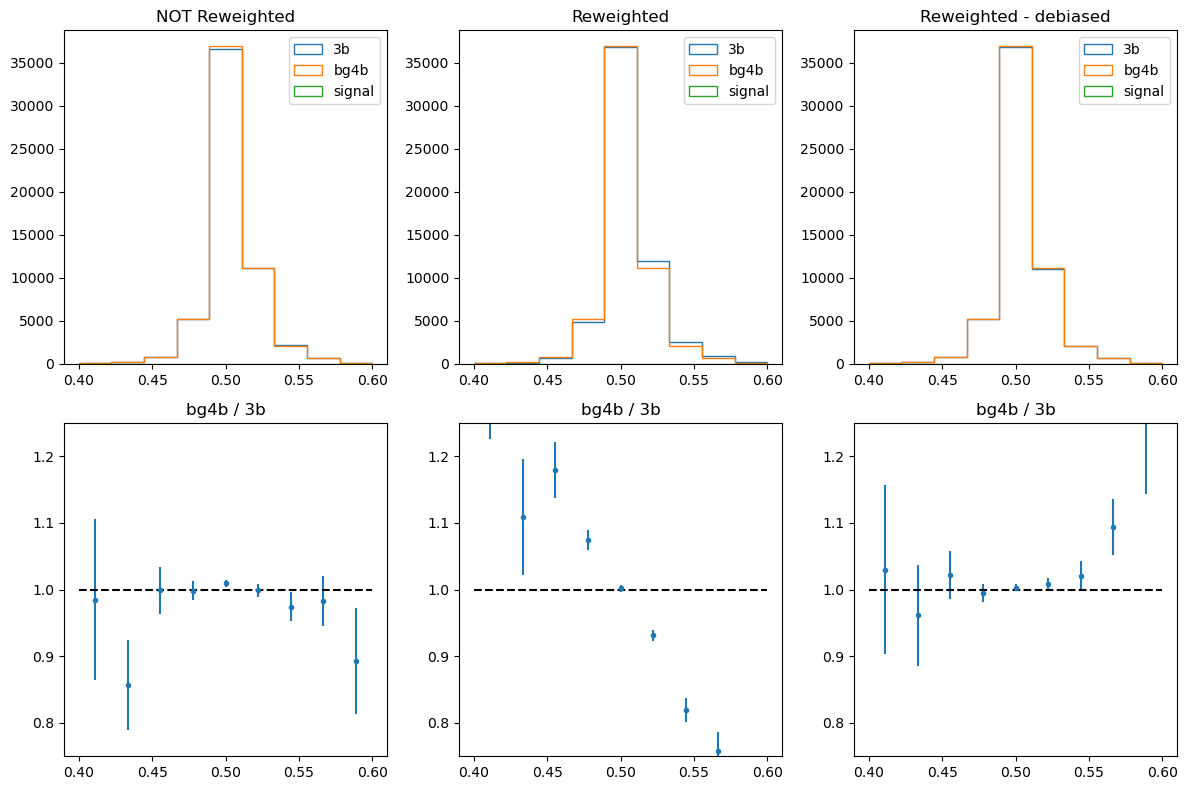

In [5]:
# q = np.linspace(0, 1, 10)
# bins = np.quantile(probs_4b_est, q)

bins = np.linspace(0.4, 0.6, 10)

reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
events_other_rw = events_other.clone()
events_other_rw.reweight(np.where(events_other_rw.is_4b, events_other_rw.weights, events_other_rw.weights * reweights))

histograms = get_histograms(events_other, probs_4b_est, bins, reweights=reweights)
hist_3b = histograms["3b"]
hist_4b = histograms["4b"]
hist_3b_rw = histograms["3b_rw"]

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3, figure=fig)

ax = fig.add_subplot(gs[0, 0])
hist_events_by_labels(events_other, probs_4b_est, bins=bins, ax=ax)
ax.set_title("NOT Reweighted")
ax.legend()

ax = fig.add_subplot(gs[1, 0])
ax.set_title("bg4b / 3b")
ax.errorbar((bins[1:] + bins[:-1]) / 2, hist_4b / hist_3b, yerr=np.sqrt(hist_4b) / hist_3b, fmt="o", markersize=3)
ax.hlines(1, bins[0], bins[-1], linestyles="--", colors="k")
ax.set_ylim((0.75, 1.25))

ax = fig.add_subplot(gs[0, 1])
hist_events_by_labels(events_other_rw, probs_4b_est, bins=bins, ax=ax)
ax.set_title("Reweighted")
ax.legend()

ax = fig.add_subplot(gs[1, 1])
ax.set_title("bg4b / 3b")
ax.errorbar((bins[1:] + bins[:-1]) / 2, hist_4b / hist_3b_rw, yerr=np.sqrt(hist_4b) / hist_3b_rw, fmt="o", markersize=3)
ax.hlines(1, bins[0], bins[-1], linestyles="--", colors="k")
ax.set_ylim((0.75, 1.25))

bias_fn = get_bias_fn(events_other, probs_4b_est, 20)
bias_3b_rw = bias_fn(probs_4b_est)

events_other_rw_db = events_other.clone()   
events_other_rw_db.reweight(np.where(events_other_rw_db.is_4b, events_other_rw_db.weights, events_other_rw_db.weights * (reweights - bias_3b_rw)))

ax = fig.add_subplot(gs[0, 2])
hist_events_by_labels(events_other_rw_db, probs_4b_est, bins=bins, ax=ax)
ax.set_title("Reweighted - debiased")
ax.legend()

hist_3b_rw_db = get_histograms(events_other_rw_db, probs_4b_est, bins, reweights=1)["3b"]
hist_3b_rw_db = np.maximum(hist_3b_rw_db, 1)

ax = fig.add_subplot(gs[1, 2])
ax.set_title("bg4b / 3b")
ax.errorbar((bins[1:] + bins[:-1]) / 2, hist_4b / hist_3b_rw_db, yerr=np.sqrt(hist_4b) / hist_3b_rw_db, fmt="o", markersize=3)
ax.hlines(1, bins[0], bins[-1], linestyles="--", colors="k")
ax.set_ylim((0.75, 1.25))

plt.tight_layout()
plt.show()


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 |

Epoch 9: 100%|██████████| 163/163 [00:08<00:00, 18.67it/s, v_num=189, val_loss=0.693, train_loss=0.693]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 163/163 [00:09<00:00, 18.00it/s, v_num=189, val_loss=0.693, train_loss=0.693]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s, avg_val_loss=0.694]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s, avg_val_loss=0.694]


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 15.83it/s, v_num=190, val_loss=0.693, train_loss=0.693]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 15.72it/s, v_num=190, val_loss=0.693, train_loss=0.693]


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


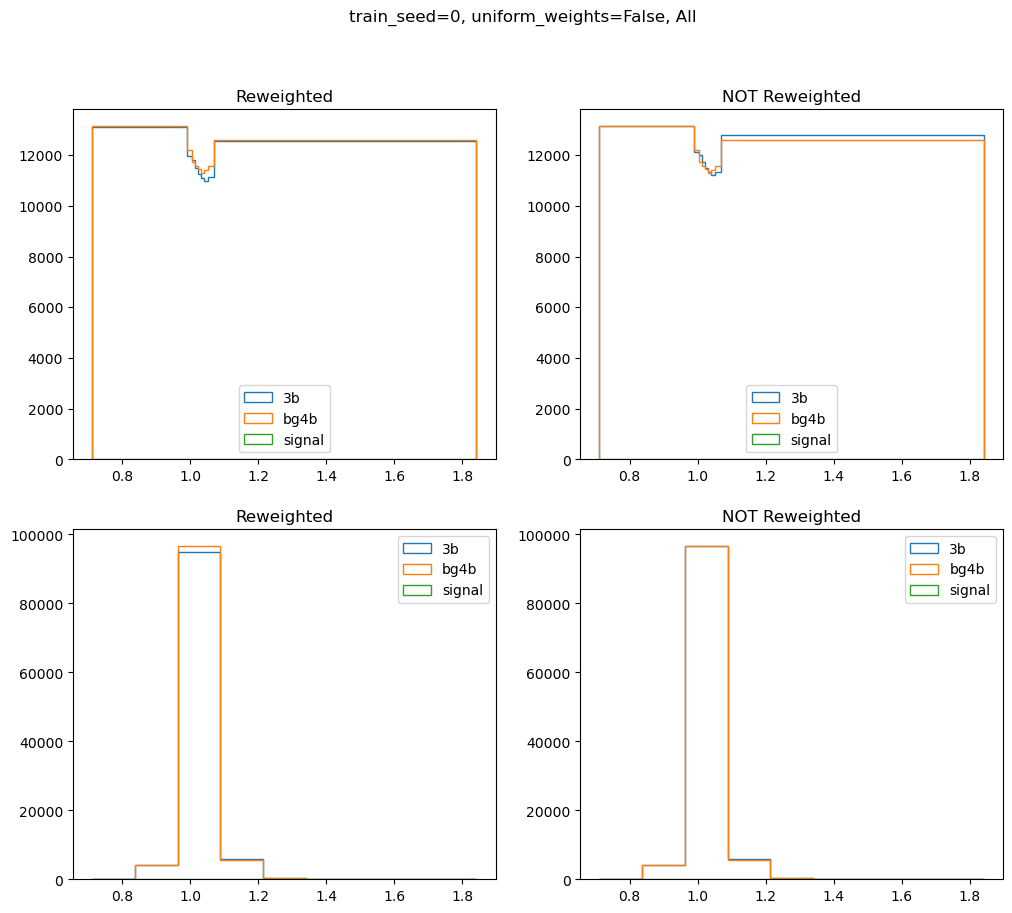

Reweighted / Quantile bins
1.5996985
NOT Reweighted / Quantile bins
1.0839219
Reweighted / Uniform bins
1.4719961
NOT Reweighted / Uniform bins
0.80766946


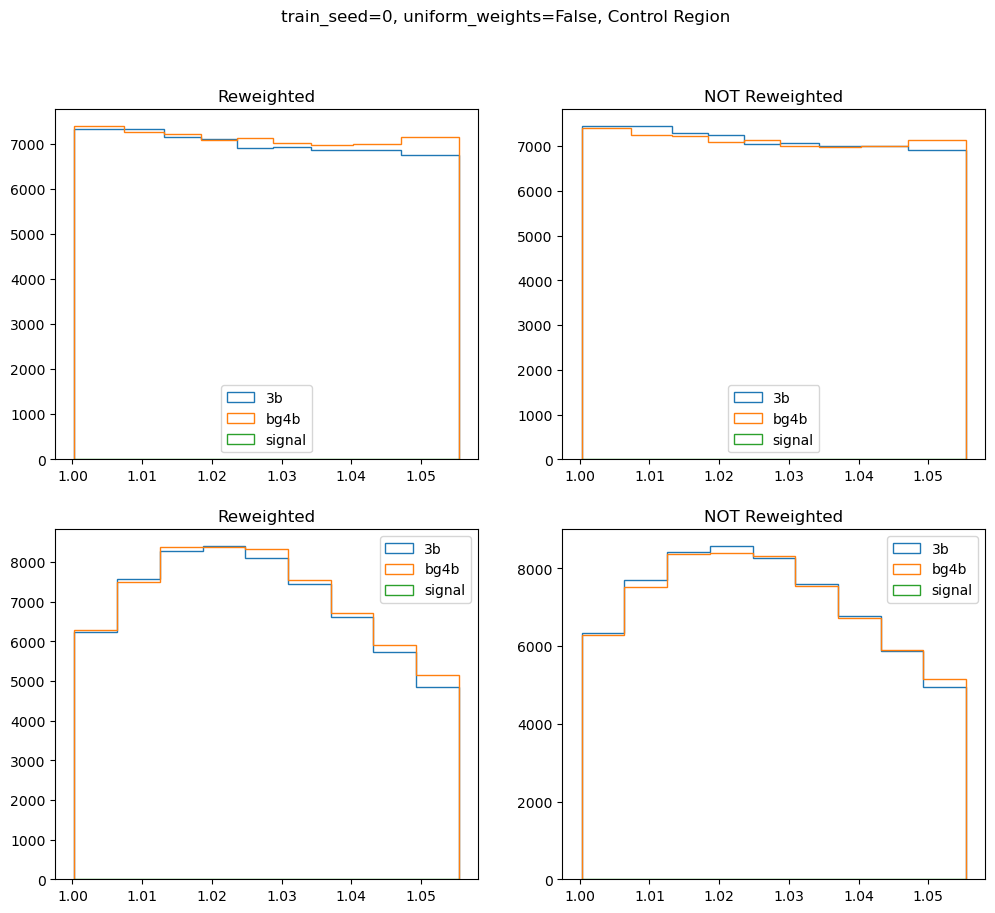

Reweighted / Quantile bins
1.3983831
NOT Reweighted / Quantile bins
1.071246
Reweighted / Uniform bins
1.4333923
NOT Reweighted / Uniform bins
1.0658512


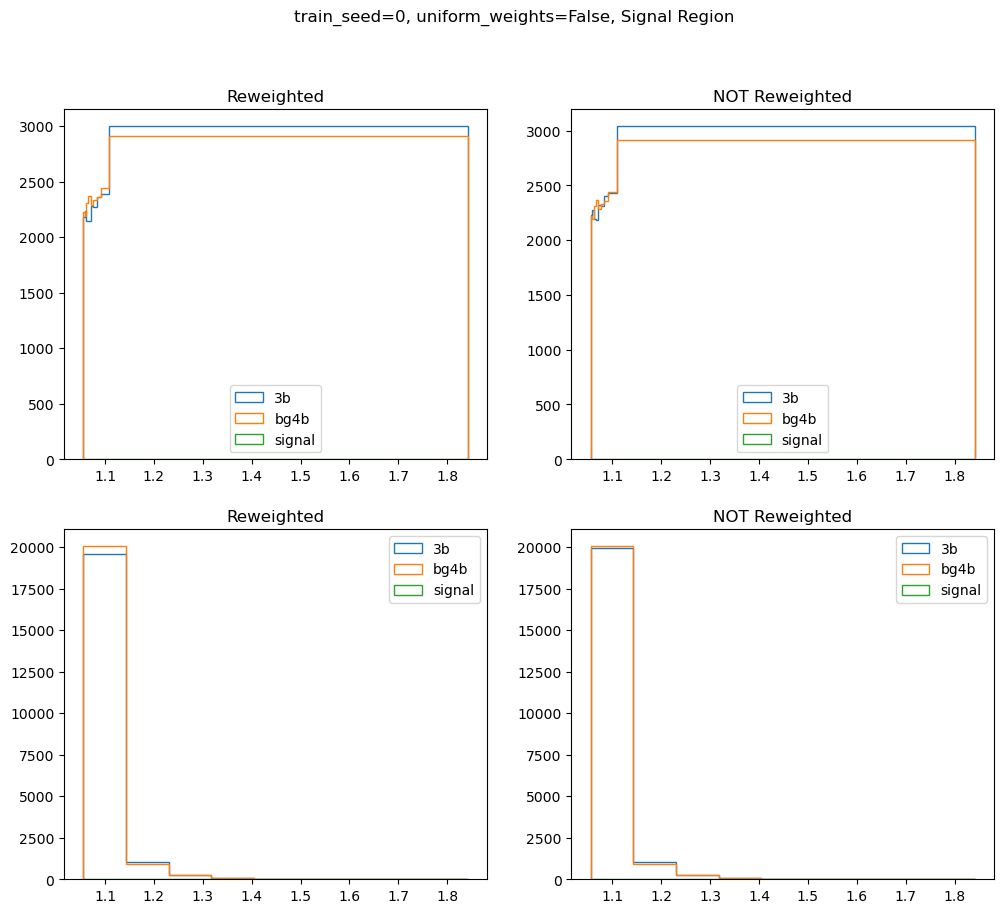

Reweighted / Quantile bins
1.5580679
NOT Reweighted / Quantile bins
1.3988087
Reweighted / Uniform bins
1.5788958
NOT Reweighted / Uniform bins
1.3547496


In [6]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from signal_region import get_SR_stats
import itertools

dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 10,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5
SR_train_ratio = 0.25

n_3b = 500_000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")

train_seeds = [0]
nbins = range(1, 11)
uniform_weights_list = [False]


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)

# Remove 4b events
df_all = df_all.iloc[:n_3b]
# give random "fourTag" labels
np.random.seed(data_seed)
df_all["fourTag"] = np.random.choice([0, 1], size=n_3b, p=[1 - ratio_4b, ratio_4b])
df_all["signal"] = False
df_all_uniform_weights = df_all.copy()
df_all_uniform_weights["weight"] = 1

sigma_dicts = []
probs_4b_ests = []
SR_stats = []

for train_seed in train_seeds:
    for uniform_weights in uniform_weights_list:
        
        if uniform_weights:
            events_all = EventsData.from_dataframe(df_all_uniform_weights, features)
        else:
            events_all = EventsData.from_dataframe(df_all, features)
            
        events_train, events_other = events_all.split(base_fvt_train_ratio, seed=data_seed)
        events_SR_train, events_tst = events_other.split(SR_train_ratio, seed=data_seed)
        
        pl.seed_everything(train_seed)
        np.random.seed(train_seed)
        
        base_fvt_hparams["train_seed"] = train_seed
        
        events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        base_fvt_train_dset = events_train.to_tensor_dataset()
        base_fvt_val_dset = events_val.to_tensor_dataset()
        
        base_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )

        base_fvt_model.fit(
            base_fvt_train_dset,
            base_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False, 
            callbacks=[],
        )
        base_fvt_model.to(device)
        base_fvt_model.eval()
        
        SR_stat = get_SR_stats(
            events_tst,
            fvt_model=base_fvt_model,
            method="smearing",
            events_SR_train=events_SR_train,
            noise_scale=0.1,
        )
        SR_stats.append(SR_stat)
        
        probs_4b_est = base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1]
        probs_4b_ests.append(probs_4b_est)
        
        SR_stats_argsort = np.argsort(SR_stat)[::-1]
        SR_stats_sorted = SR_stat[SR_stats_argsort]

        weights = events_tst.weights[SR_stats_argsort]
        is_4b = events_tst.is_4b[SR_stats_argsort]
        cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

        w_4b_SR_ratio = 0.2
        w_4b_CR_ratio = 0.8

        SR_cut, CR_cut = None, None
        for i in range(1, len(cumul_4b_ratio)):
            if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
                SR_cut = SR_stats_sorted[i - 1]
            if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
                CR_cut = SR_stats_sorted[i - 1]
            if SR_cut is not None and CR_cut is not None:
                break

        # If the cut is not found, set the cut to the minimum value
        # Both SR and CR cuts should be different
        if SR_cut is None:
            SR_cut = SR_stats_sorted[-1]
        if CR_cut is None:
            CR_cut = SR_stats_sorted[-1]
        if SR_cut == CR_cut:
            raise ValueError("SR and CR cuts are the same")

        SR_idx = SR_stat >= SR_cut
        events_tst_SR = events_tst[SR_idx]

        CR_idx = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
        events_tst_CR = events_tst[CR_idx]
        
        events_CR_train, events_CR_val = events_tst_CR.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_CR_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_CR_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        CR_fvt_train_dset = events_CR_train.to_tensor_dataset()
        CR_fvt_val_dset = events_CR_val.to_tensor_dataset()
        
        CR_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )
        
        CR_fvt_model.fit(
            CR_fvt_train_dset,
            CR_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False,
            callbacks=[],
        )
        CR_fvt_model.to(device)
        CR_fvt_model.eval()
        
        probs_4b_est_CR = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
        events_tst_clone = events_tst.clone()
        reweights = probs_4b_est_CR / (1 - probs_4b_est_CR) * (ratio_4b / (1 - ratio_4b))
        events_tst_clone.reweight(
            np.where(events_tst_clone.is_4b, 
                    events_tst_clone.weights, 
                    events_tst_clone.weights * reweights)
        )
        
        sigma_dict = {}
        
        for nbin, quantile, reweighted, region in itertools.product(nbins, 
                                                                    [True, False], 
                                                                    [True, False], 
                                                                    ["all", "CR", "SR"]):
            
            if region == "all":
                region_idx = np.ones_like(SR_stat, dtype=bool)
            elif region == "CR":
                region_idx = CR_idx
            elif region == "SR":
                region_idx = SR_idx
            else:
                raise ValueError("Invalid region")
            
            if quantile:
                q = np.linspace(0, 1, nbin + 1)
                bins = np.quantile(SR_stat[region_idx], q)
            else:
                bins = np.linspace(np.min(SR_stat[region_idx]), np.max(SR_stat[region_idx]), nbin)
                
            if reweighted:
                sigma_avg = get_sigma_avg(events_tst_clone[region_idx], 
                                          SR_stat[region_idx], 
                                          bins, 
                                          reweights[region_idx])
            else:
                sigma_avg = get_sigma_avg(events_tst[region_idx], 
                                          SR_stat[region_idx], 
                                          bins, 
                                          reweights=1)
        
            sigma_dict[(uniform_weights, reweighted, region, quantile, nbin)] = sigma_avg

        sigma_dicts.append(sigma_dict)
            
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, All")
        plot_reweighted_samples(events_tst_clone, events_tst, SR_stat, fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "all", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "all", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "all", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "all", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Control Region")
        plot_reweighted_samples(events_tst_clone[CR_idx], events_tst[CR_idx], SR_stat[CR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "CR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "CR", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "CR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "CR", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Signal Region")
        plot_reweighted_samples(events_tst_clone[SR_idx], events_tst[SR_idx], SR_stat[SR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "SR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "SR", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "SR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "SR", False, 10)])
        
        
probs_4b_est = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]

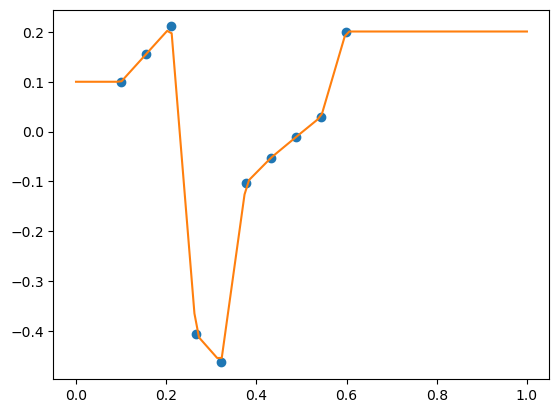

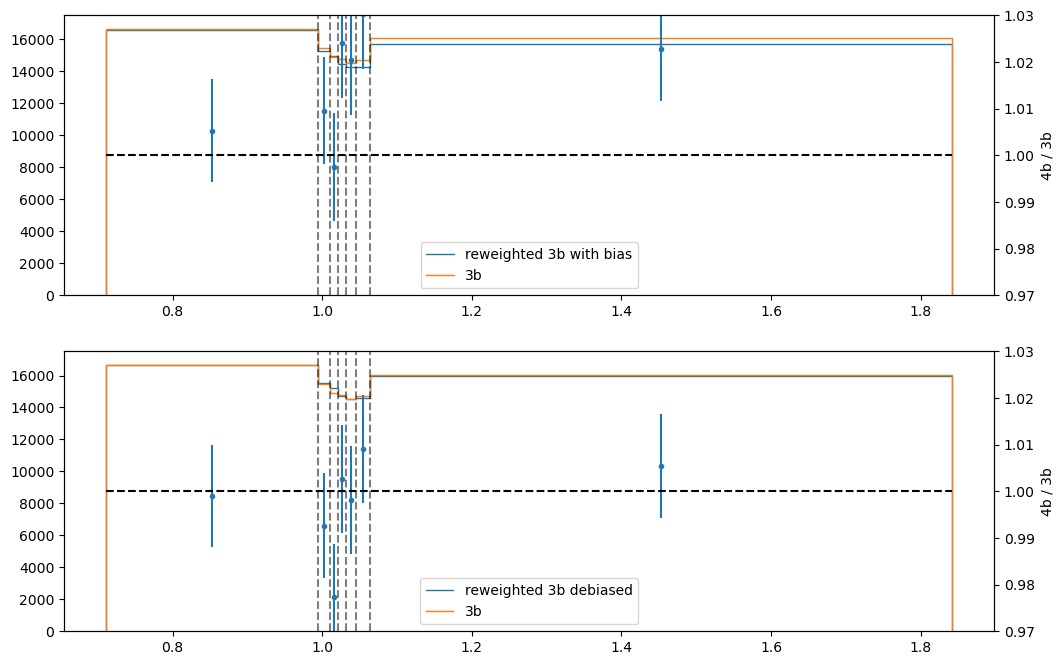

In [7]:
# Estimating Calibration Error of the FvT model
# Just use piecewise linear function for now

nbins = 7
calibration_nbins = 10
calibration_bins = np.linspace(np.min(probs_4b_est), np.max(probs_4b_est), calibration_nbins + 1)

midpoints = (calibration_bins[1:] + calibration_bins[:-1]) / 2

hist_4b, _ = np.histogram(probs_4b_est, bins=calibration_bins, weights=(events_tst.weights * events_tst.is_4b))
hist_all, _ = np.histogram(probs_4b_est, bins=calibration_bins, weights=events_tst.weights)
mean_probs_4b = hist_4b / hist_all
calibration_error = midpoints - mean_probs_4b

def piecewise_linear(x_knots, y_knots):
    def piecewise_linear_inner(x):
        return np.interp(x, x_knots, y_knots)
    return piecewise_linear_inner

plt.plot(midpoints, calibration_error, "o")
x_range = np.linspace(0, 1, 100)
calibration_error_fn = piecewise_linear(midpoints, calibration_error)
plt.plot(x_range, calibration_error_fn(x_range))
plt.show()

bias = calibration_error_fn(probs_4b_est) * (1 / (1 - probs_4b_est))**2

q = np.linspace(0, 1, nbins + 1)
bins = np.quantile(SR_stat, q)
# bins = np.linspace(np.min(SR_stat), np.max(SR_stat), nbins + 1)
hist_bias, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                            bins=bins, weights=(events_tst.weights * bias)[events_tst_clone.is_3b])
hist_3b, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                          bins=bins, weights=events_tst_clone.weights[events_tst_clone.is_3b])
hist_3b_sq, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                             bins=bins, weights=(events_tst_clone.weights * reweights)[events_tst_clone.is_3b])
hist_4b, _ = np.histogram(SR_stat[events_tst_clone.is_4b], bins=bins, weights=events_tst_clone.weights[events_tst_clone.is_4b])

sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
sigma_bias_fixed = (hist_4b - (hist_3b - hist_bias)) / np.sqrt(hist_4b + hist_3b_sq)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.stairs(hist_3b, bins, label="reweighted 3b with bias")
ax.stairs(hist_4b, bins, label="3b")
ax.legend()

ax2 = ax.twinx()
ax2.errorbar((bins[1:] + bins[:-1]) / 2, hist_4b / hist_3b, yerr=np.sqrt(hist_4b / hist_3b**2 + hist_3b_sq / hist_3b**2), fmt="o", markersize=3, label="4b / 3b")
ax2.set_ylim((0.97, 1.03))
ax2.set_ylabel("4b / 3b")
ax2.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
ymin, ymax = ax2.get_ylim()
ax2.vlines(bins[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)

ax = fig.add_subplot(gs[1, 0])
ax.stairs(hist_3b - hist_bias, bins, label="reweighted 3b debiased")
ax.stairs(hist_4b, bins, label="3b")
ax.legend()

ax2 = ax.twinx()
ax2.errorbar((bins[1:] + bins[:-1]) / 2, hist_4b / (hist_3b - hist_bias), 
             yerr=np.sqrt(hist_4b / (hist_3b - hist_bias)**2 + hist_3b_sq / (hist_3b - hist_bias)**2), fmt="o", markersize=3, label="4b / 3b")
ax2.set_ylim((0.97, 1.03))
ax2.set_ylabel("4b / 3b")
ax2.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
ymin, ymax = ax2.get_ylim()
ax2.vlines(bins[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)

plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

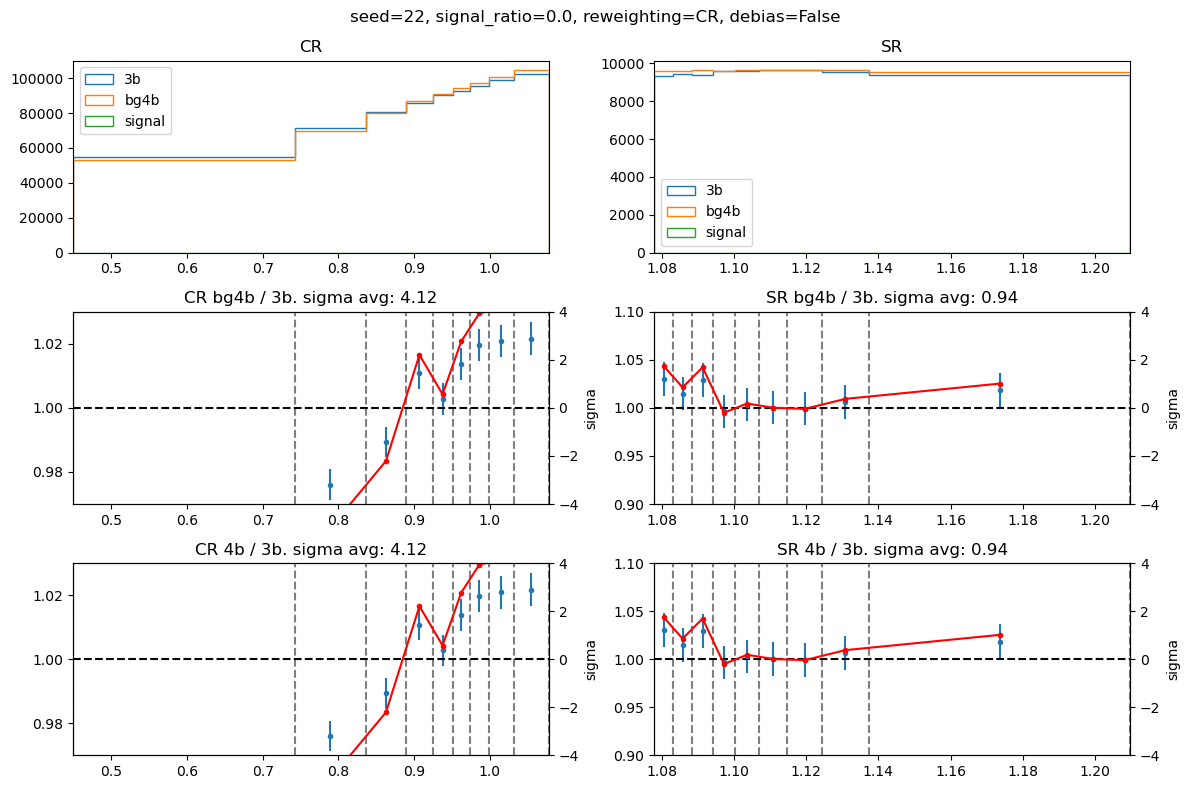

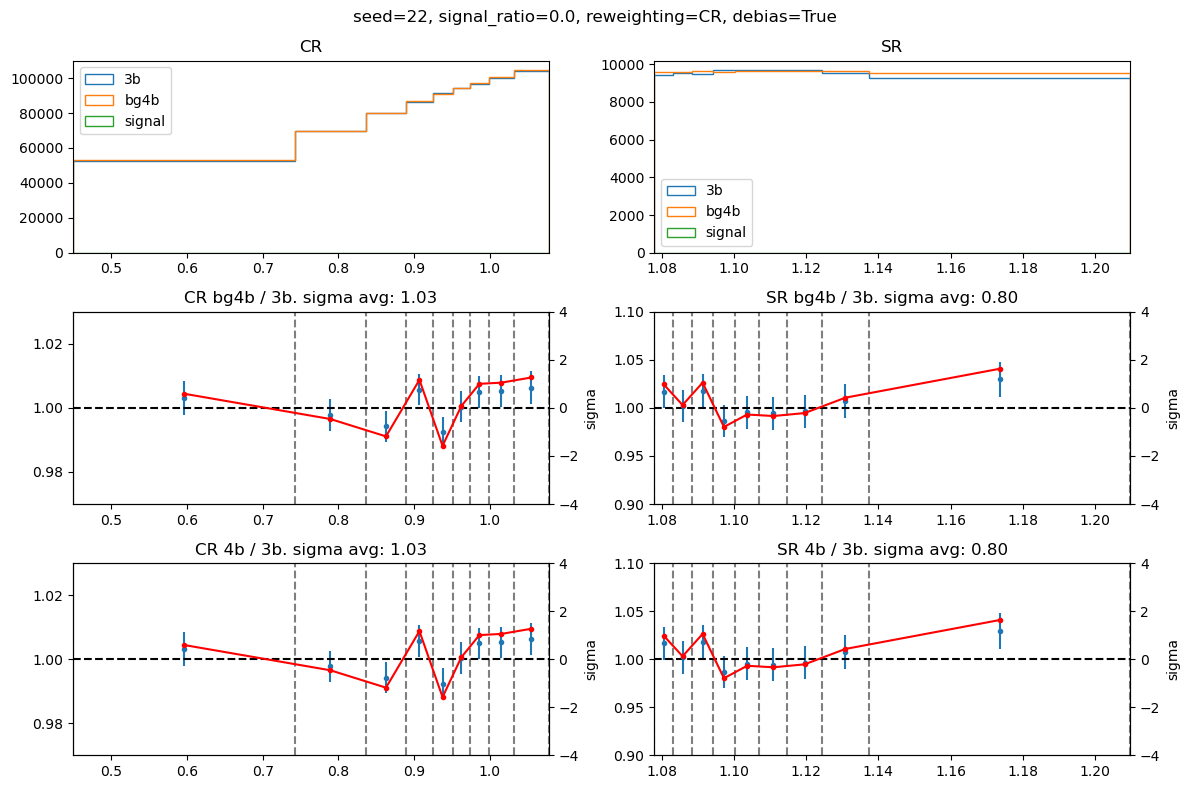

 11%|█         | 1/9 [00:23<03:11, 23.95s/it]

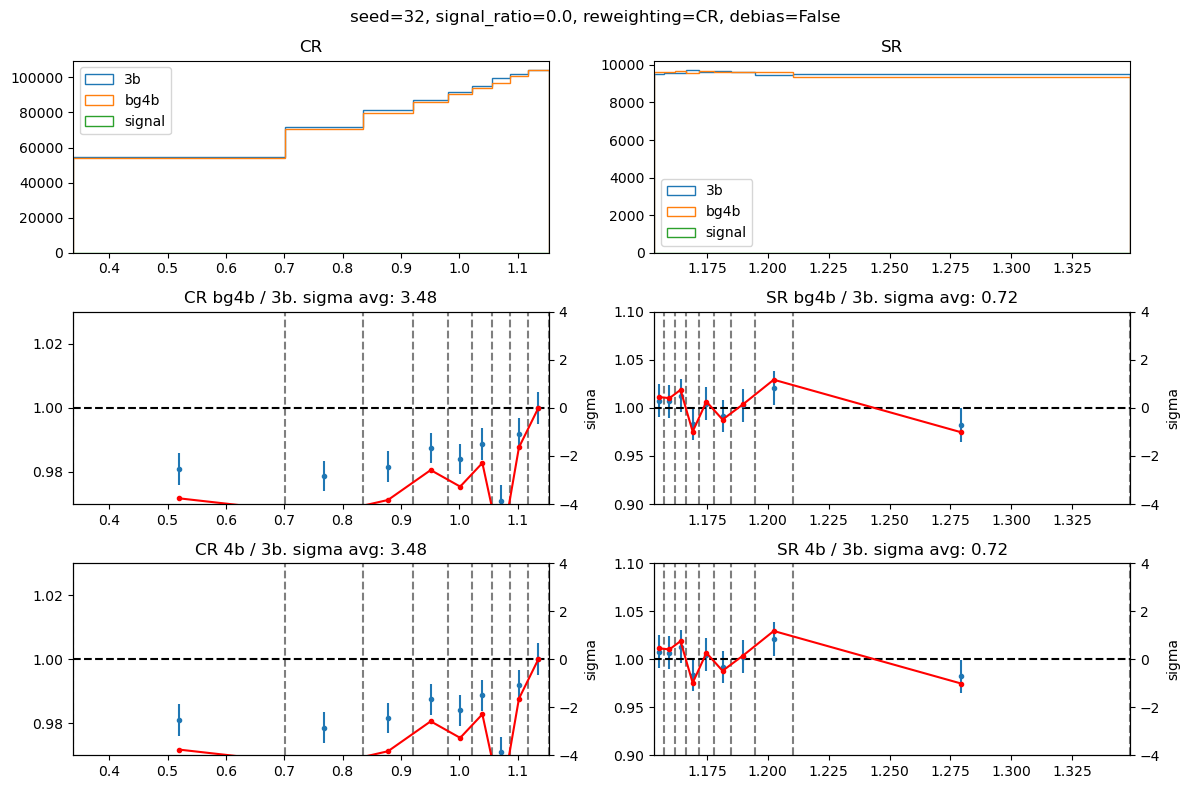

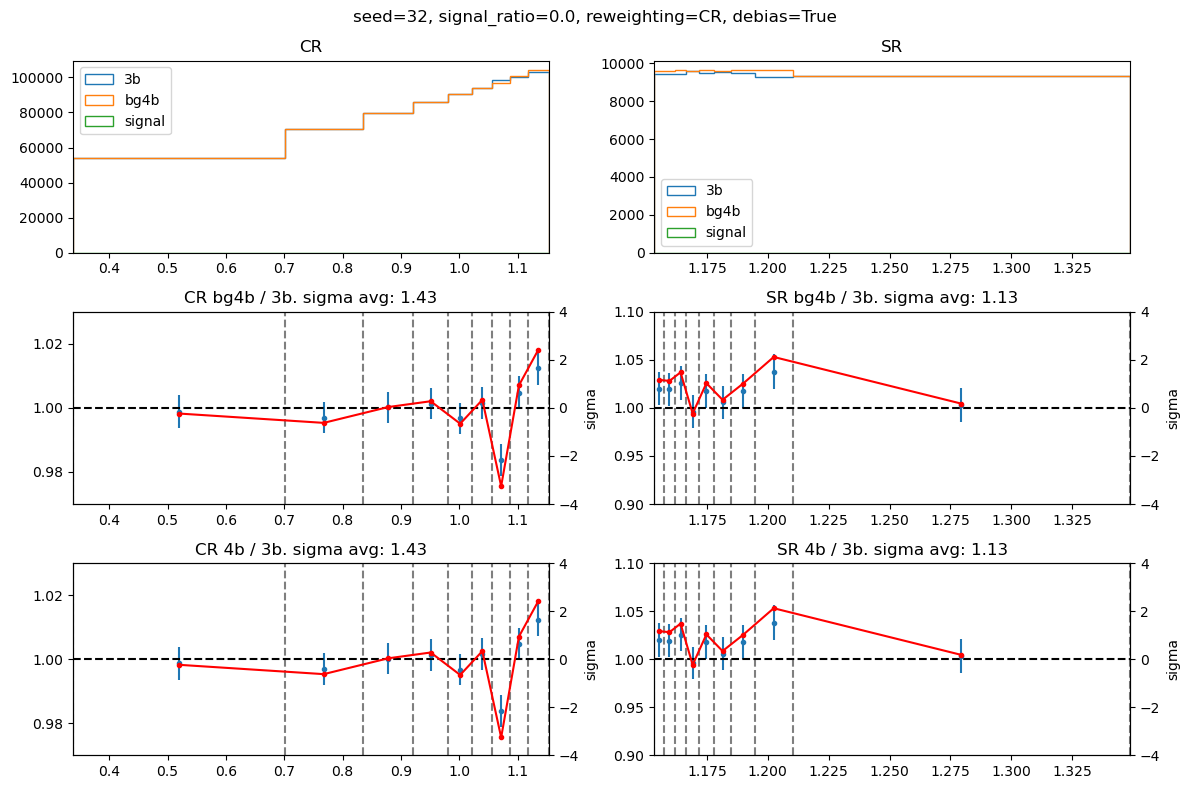

 22%|██▏       | 2/9 [00:47<02:45, 23.70s/it]

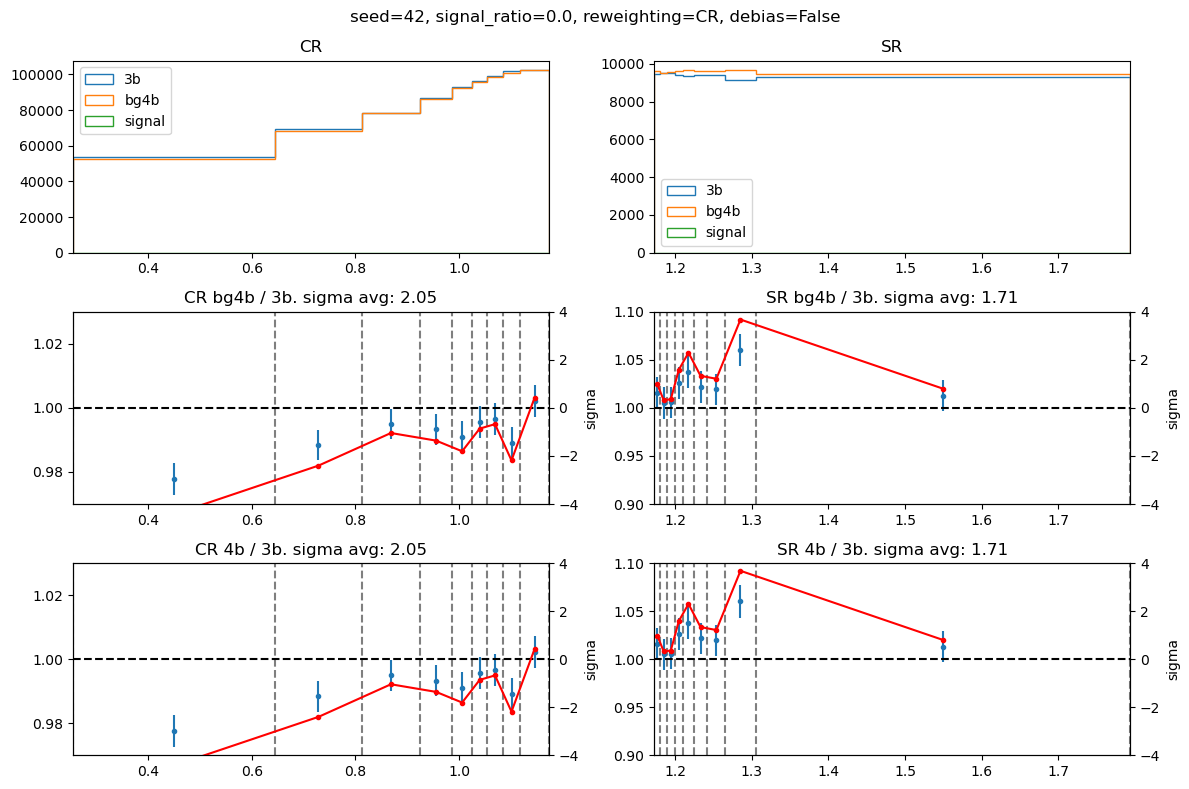

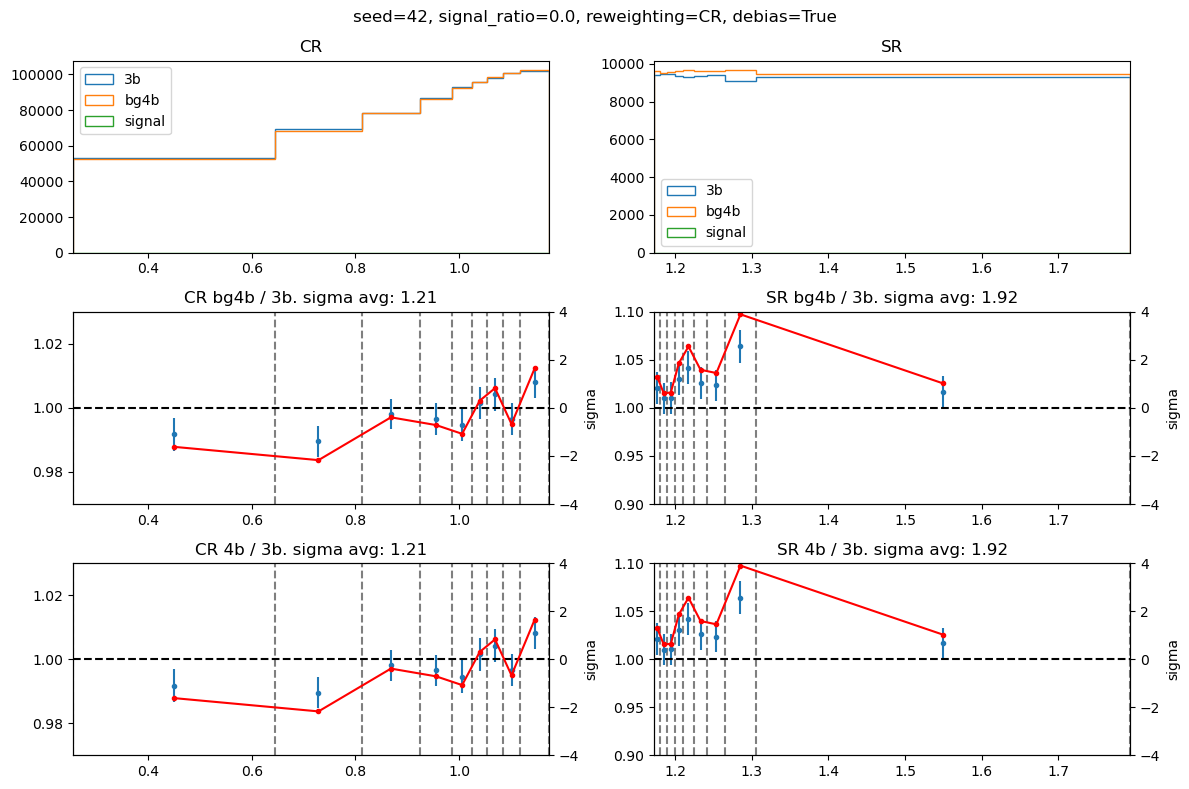

 33%|███▎      | 3/9 [01:11<02:22, 23.73s/it]

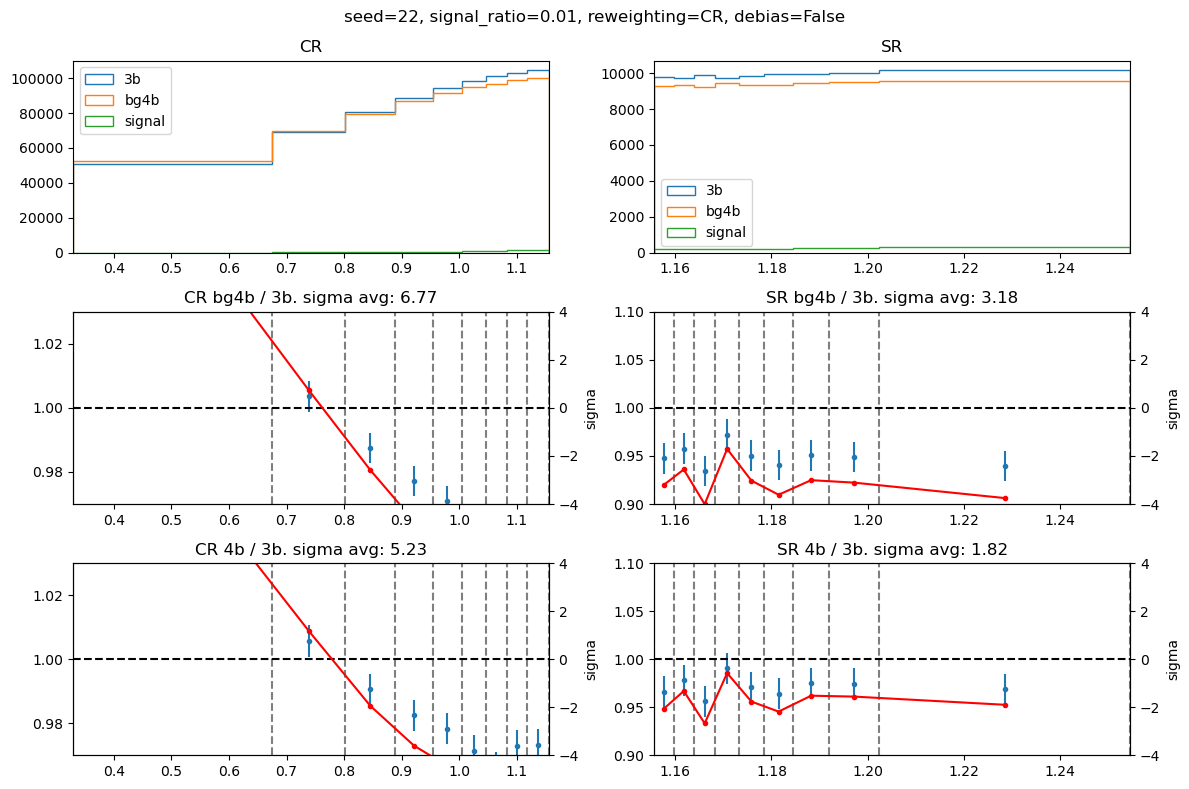

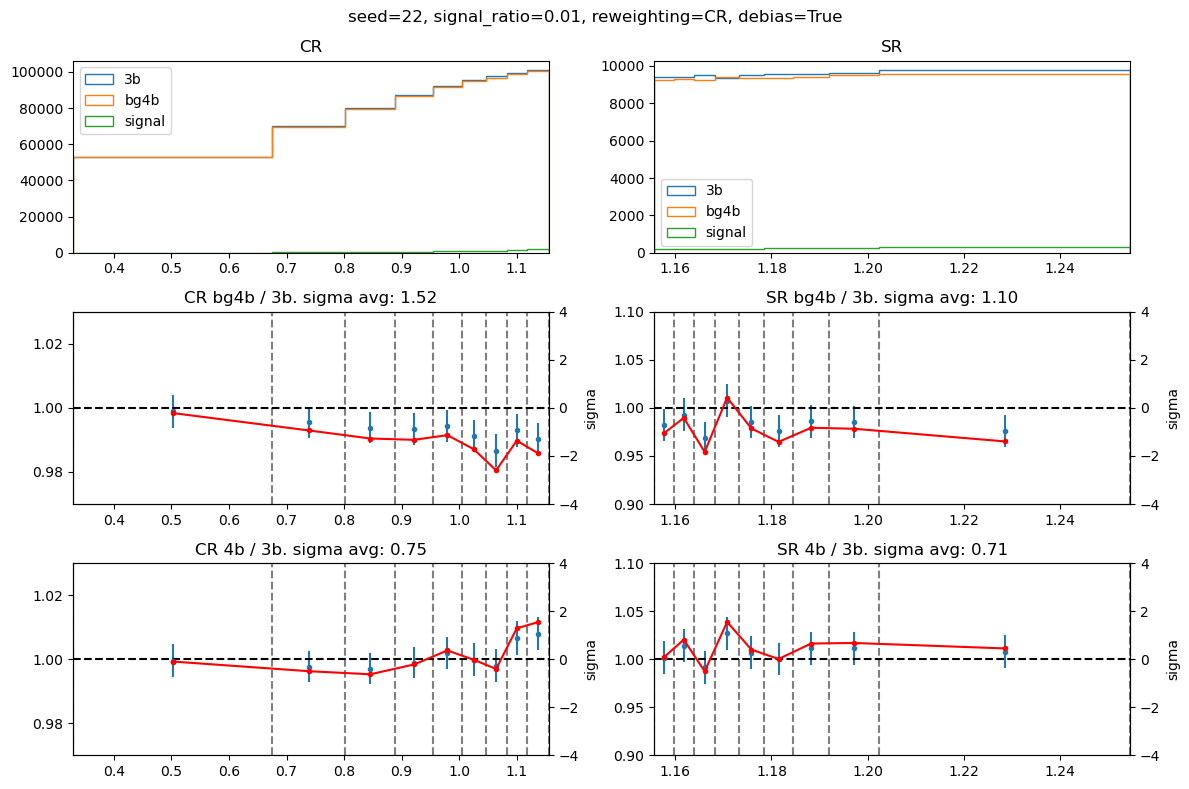

 44%|████▍     | 4/9 [01:34<01:58, 23.62s/it]

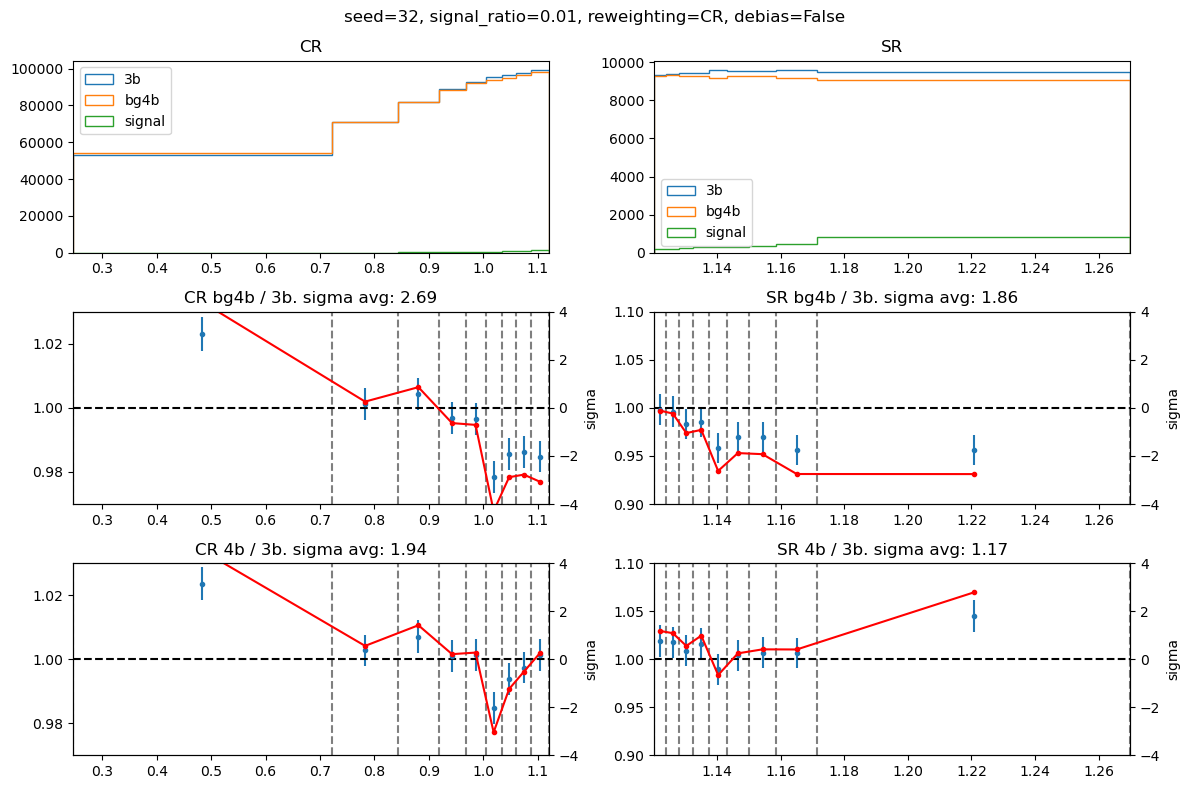

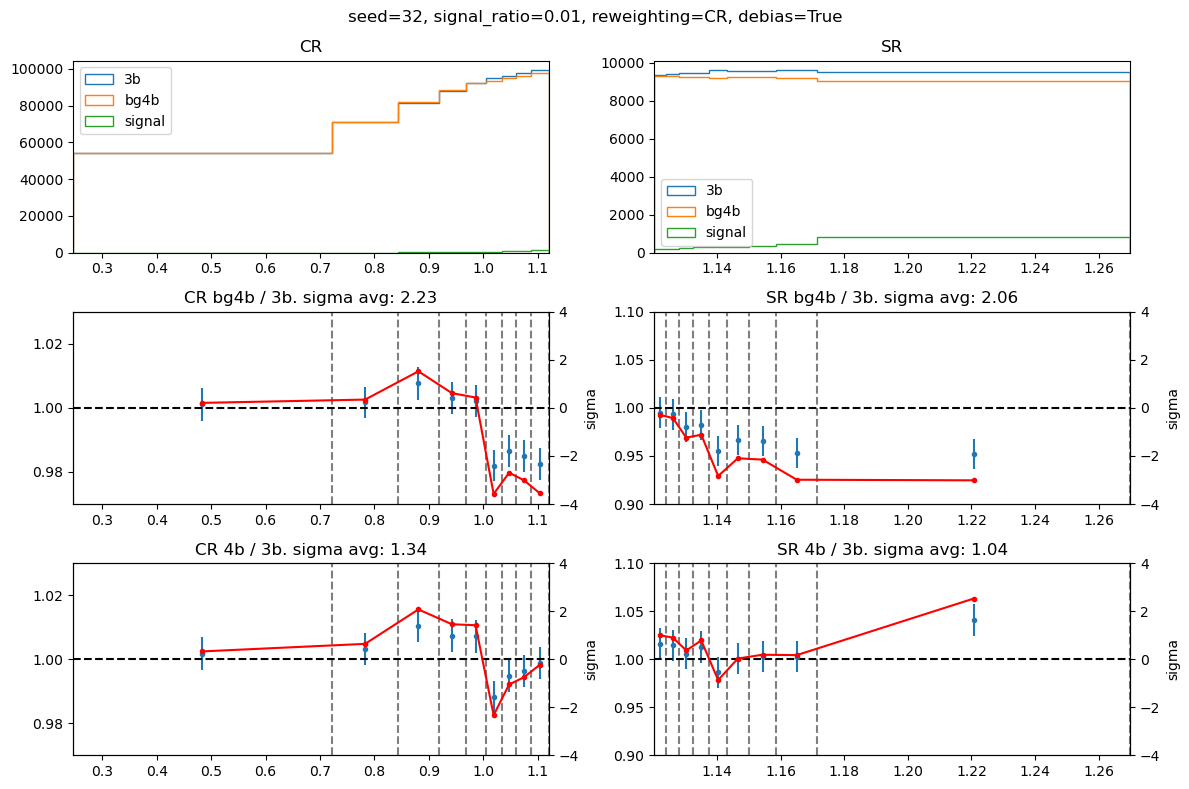

 56%|█████▌    | 5/9 [01:58<01:34, 23.61s/it]

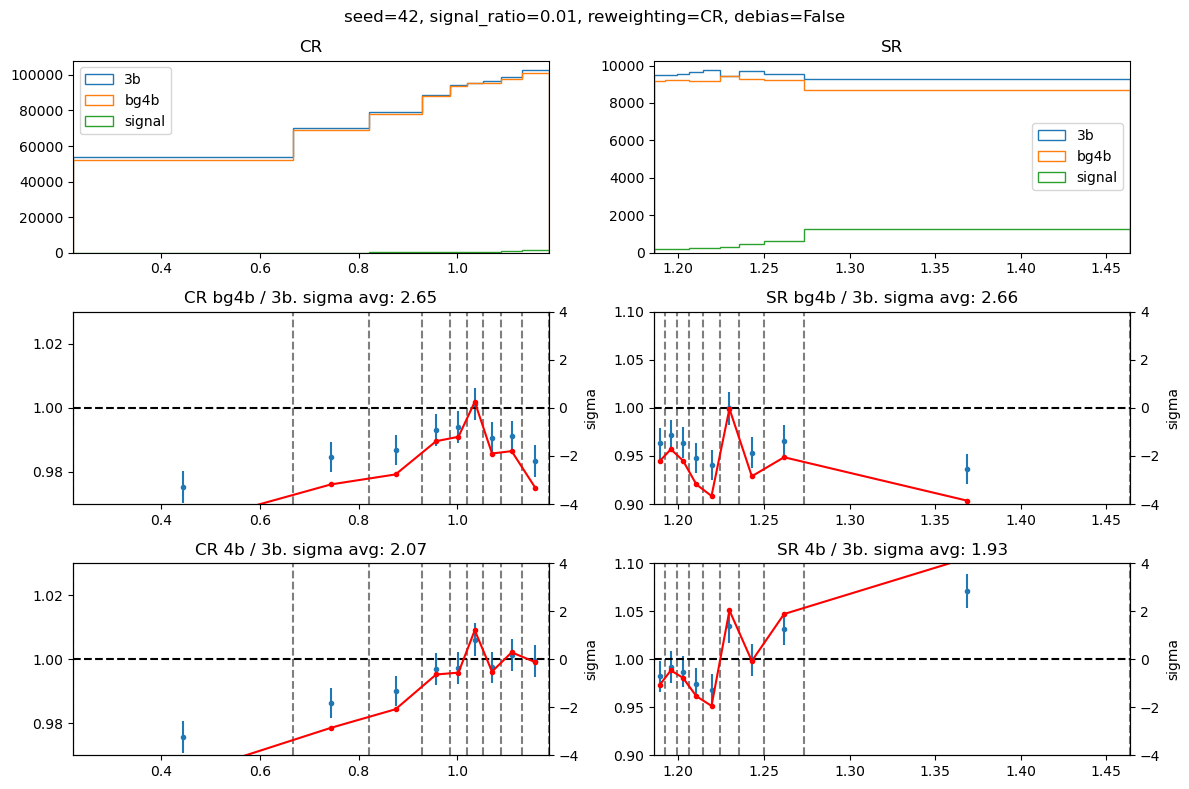

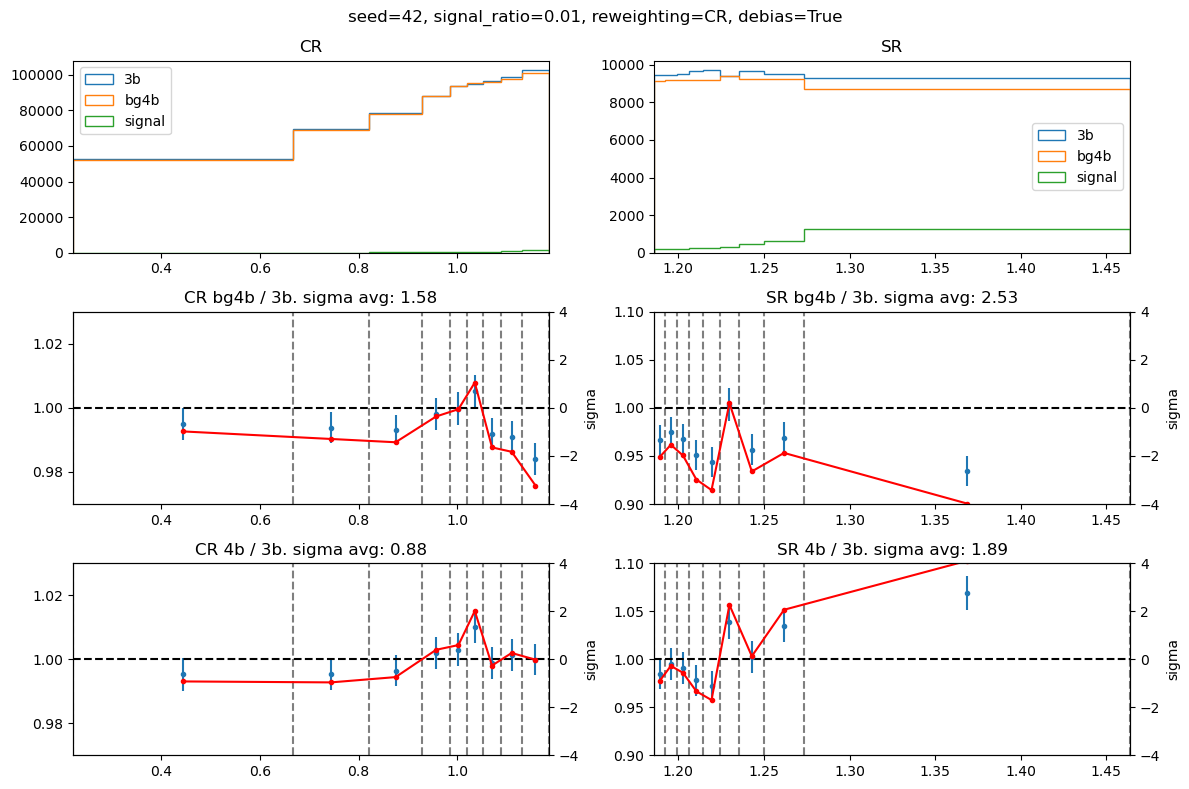

 67%|██████▋   | 6/9 [02:22<01:10, 23.66s/it]

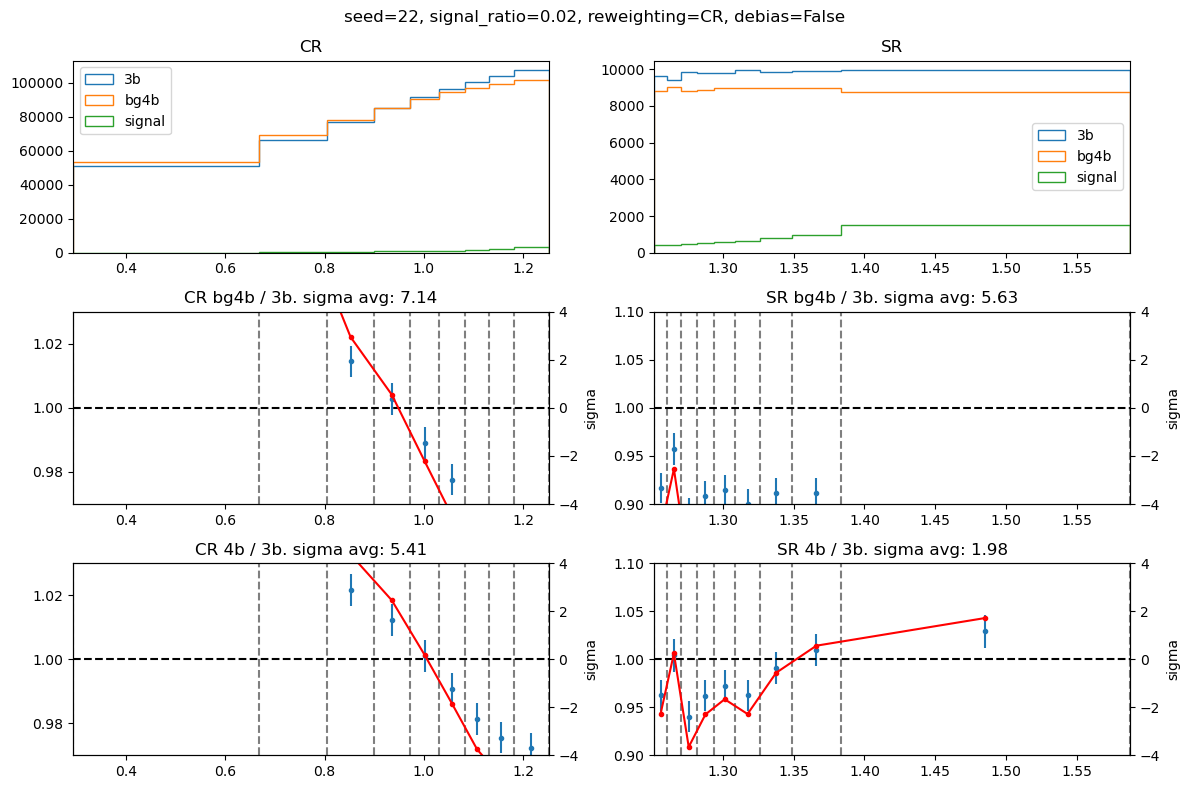

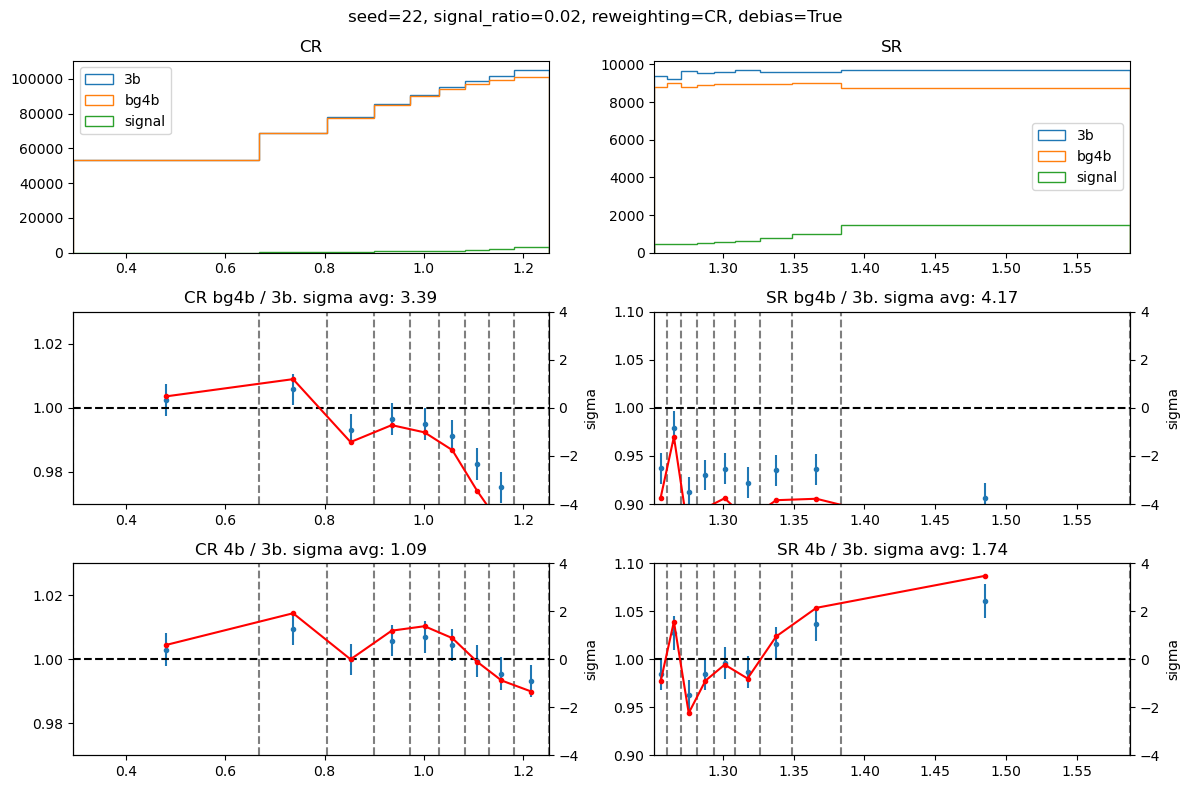

 78%|███████▊  | 7/9 [02:45<00:47, 23.71s/it]

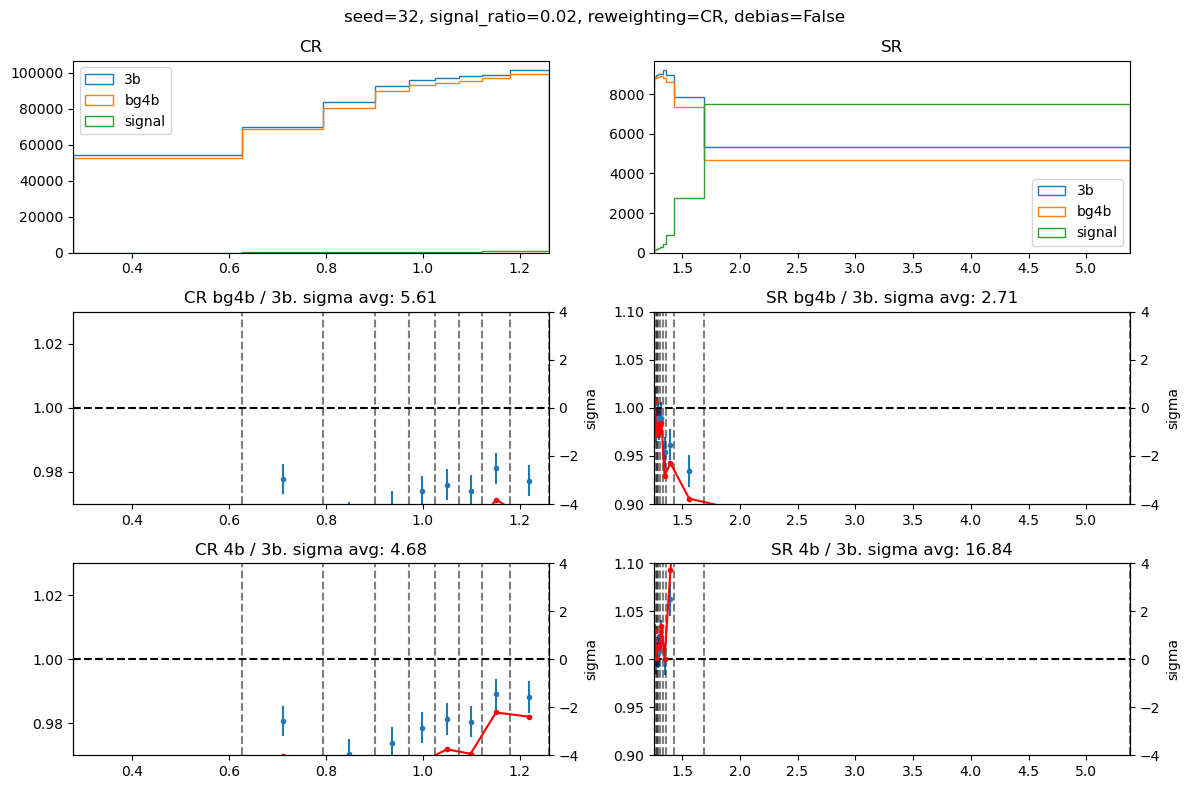

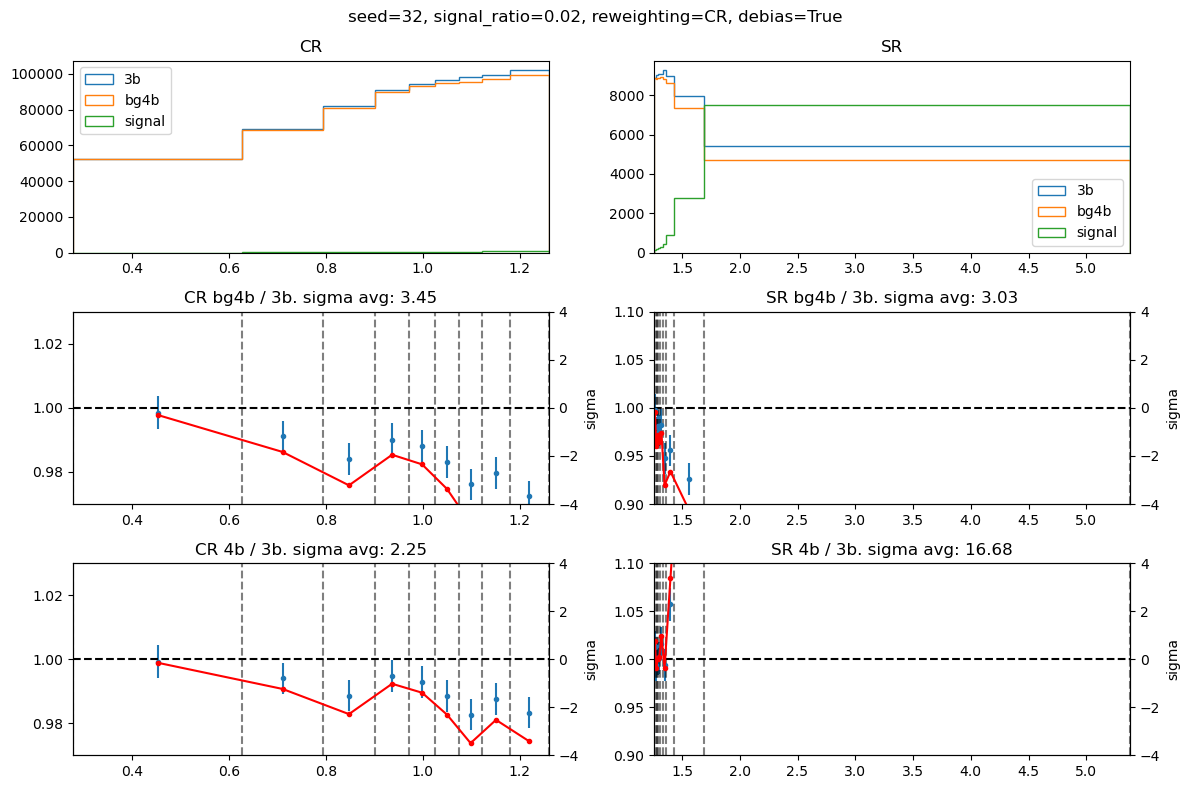

 89%|████████▉ | 8/9 [03:09<00:23, 23.71s/it]

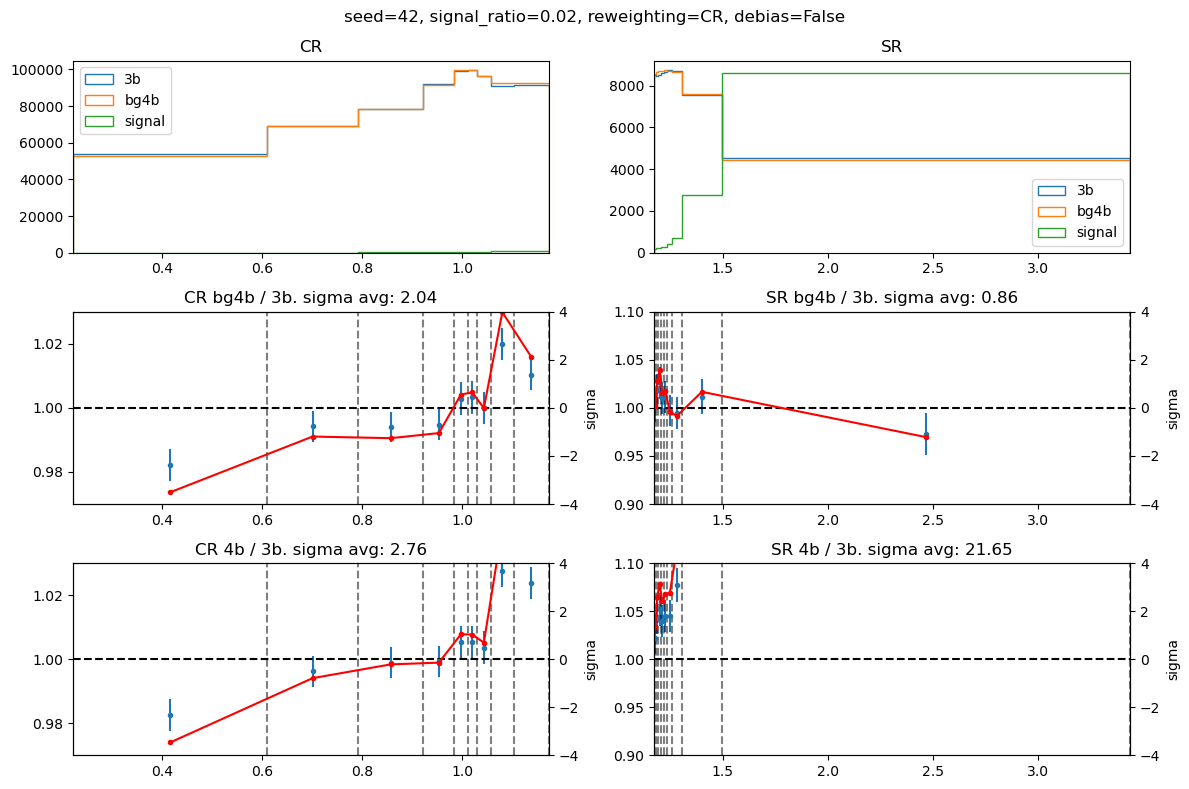

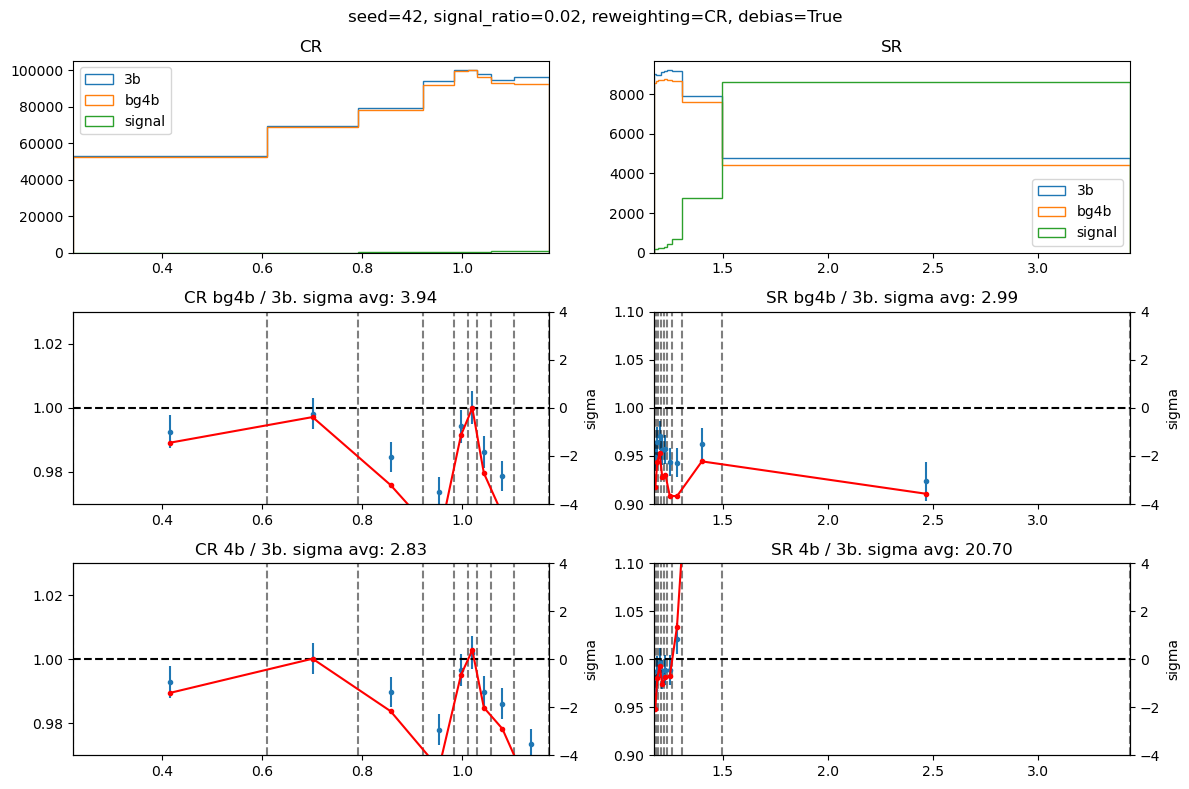

100%|██████████| 9/9 [03:33<00:00, 23.73s/it]


In [8]:
import matplotlib.pyplot as plt
from tst_info import TSTInfo

plt.rcParams["lines.markersize"] = 3

n_3b = 140_0000
device = torch.device("cuda")
do_tqdm = True
calibration_nbin = 20
rw_methods = ["CR"]
debias_list = [False, True]

hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"],
    "n_3b": n_3b,
    # "signal_ratio": 0.0,
    "seed": lambda x: x in [22, 32, 42],
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])
draw_routine(hashes, rw_methods=rw_methods, debias_list=debias_list, calibration_nbin=calibration_nbin)

In [9]:
import pandas as pd
from scipy import stats

experiment_name = "counting_test_high_4b_in_CR"
n_3b = 140_0000
df_debiased = pd.read_csv(f"data/tsv/tst_results_summary_{experiment_name}_n_3b={n_3b}_debiased.tsv", 
                          sep="\t")
df_biased = pd.read_csv(f"data/tsv/tst_results_summary_{experiment_name}_n_3b={n_3b}.tsv", 
                              sep="\t")

df_debiased["p_SR"] = stats.chi2.sf(df_debiased["df_SR"] * df_debiased["sigma_avg_SR"]**2, df=df_debiased["df_SR"])
df_debiased["p_CR"] = stats.chi2.sf(df_debiased["df_CR"] * df_debiased["sigma_avg_CR"]**2, df=df_debiased["df_CR"])
df_biased["p_SR"] = stats.chi2.sf(df_biased["df_SR"] * df_biased["sigma_avg_SR"]**2, df=df_biased["df_SR"])
df_biased["p_CR"] = stats.chi2.sf(df_biased["df_CR"] * df_biased["sigma_avg_CR"]**2, df=df_biased["df_CR"])

sig_level = 0.05

df_debiased["reject_SR"] = df_debiased["p_SR"] < sig_level
df_debiased["reject_CR"] = df_debiased["p_CR"] < sig_level
df_biased["reject_SR"] = df_biased["p_SR"] < sig_level
df_biased["reject_CR"] = df_biased["p_CR"] < sig_level

In [10]:
display(df_debiased.groupby(["signal_ratio", "reweight", "nbin"]).mean())
display(df_biased.groupby(["signal_ratio", "reweight", "nbin"]).mean())

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio reweight nbin                                          
0.00         CR       1     25.0      2.620214           2.620214   
                      2     25.0      2.117144           2.117144   
                      3     25.0      1.870934           1.870934   
                      4     25.0      1.741132           1.741132   
                      5     25.0      1.616755           1.616755   
                      6     25.0      1.541894           1.541894   
                      7     25.0      1.462565           1.462565   
                      8     25.0      1.455360           1.455360   
                      9     25.0      1.386560           1.386560   
             base     1     25.0      2.187307           2.187307   
                      2     25.0      1.907160           1.907160   
                      3     25.0      1.674369           1.674369   
                      4     25.0      1.569647           1.569647   
                      5     25.0      1.482928           1.482928   
                      6     25.0      1.411792           1.411792   
                      7     25.0      1.346291           1.346291   
                      8     25.0      1.357680           1.357680   
                      9     25.0      1.301749           1.301749   
0.01         CR       1     25.0      2.564017           3.592187   
                      2     25.0      2.268692           2.832957   
                      3     25.0      1.986671           2.397549   
                      4     25.0      1.843463           2.156663   
                      5     25.0      1.751947           2.024792   
                      6     25.0      1.657045           1.877764   
                      7     25.0      1.607264           1.810457   
                      8     25.0      1.540234           1.712574   
                      9     25.0      1.504347           1.664137   
             base     1     25.0      1.966732           4.323836   
                      2     25.0      1.850196           3.302379   
                      3     25.0      1.642356           2.783534   
                      4     25.0      1.537039           2.480975   
                      5     25.0      1.492086           2.321748   
                      6     25.0      1.400574           2.135992   
                      7     25.0      1.383963           2.034250   
                      8     25.0      1.327406           1.933837   
                      9     25.0      1.304871           1.857047   
0.02         CR       1     25.0     15.787348           6.959242   
                      2     25.0     15.948646           5.338376   
                      3     25.0     15.654562           4.551873   
                      4     25.0     15.178996           4.058465   
                      5     25.0     14.593765           3.668214   
                      6     25.0     13.996919           3.415713   
                      7     25.0     13.435205           3.220741   
                      8     25.0     12.900492           3.025102   
                      9     25.0     12.405484           2.874987   
             base     1     25.0      3.651257          20.589249   
                      2     25.0      3.727480          16.872021   
                      3     25.0      3.847388          14.585263   
                      4     25.0      3.993095          13.007249   
                      5     25.0      3.983369          11.802349   
                      6     25.0      3.947239          10.890107   
                      7     25.0      3.866935          10.156028   
                      8     25.0      3.760743           9.547256   
                      9     25.0      3.640137           9.035696   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio reweight nbin                                    
0.00         CR       1         0.778

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio reweight nbin                                          
0.00         CR       1     25.0      3.582228           3.582228   
                      2     25.0      2.790602           2.790602   
                      3     25.0      2.408827           2.408827   
                      4     25.0      2.176287           2.176287   
                      5     25.0      2.015086           2.015086   
                      6     25.0      1.890211           1.890211   
                      7     25.0      1.785191           1.785191   
                      8     25.0      1.756079           1.756079   
                      9     25.0      1.672238           1.672238   
             base     1     25.0      3.326207           3.326207   
                      2     25.0      2.660259           2.660259   
                      3     25.0      2.285141           2.285141   
                      4     25.0      2.066021           2.066021   
                      5     25.0      1.913512           1.913512   
                      6     25.0      1.805579           1.805579   
                      7     25.0      1.702095           1.702095   
                      8     25.0      1.678369           1.678369   
                      9     25.0      1.599594           1.599594   
0.01         CR       1     25.0      4.290121           4.951555   
                      2     25.0      3.403494           3.722128   
                      3     25.0      2.884974           3.121374   
                      4     25.0      2.579575           2.763038   
                      5     25.0      2.381761           2.549705   
                      6     25.0      2.232620           2.354492   
                      7     25.0      2.134011           2.245612   
                      8     25.0      2.025722           2.124855   
                      9     25.0      1.947994           2.032284   
             base     1     25.0      2.779821           5.281382   
                      2     25.0      2.400664           3.951709   
                      3     25.0      2.051513           3.280968   
                      4     25.0      1.899035           2.911837   
                      5     25.0      1.793139           2.674045   
                      6     25.0      1.682285           2.476366   
                      7     25.0      1.630308           2.327384   
                      8     25.0      1.562283           2.205552   
                      9     25.0      1.502443           2.102355   
0.02         CR       1     25.0     18.203453           5.679723   
                      2     25.0     17.298147           4.521155   
                      3     25.0     16.624852           3.895761   
                      4     25.0     15.948413           3.513108   
                      5     25.0     15.237625           3.186302   
                      6     25.0     14.557270           2.973663   
                      7     25.0     13.936633           2.823041   
                      8     25.0     13.355591           2.644442   
                      9     25.0     12.823397           2.519501   
             base     1     25.0      4.311304          21.228635   
                      2     25.0      4.442896          17.028227   
                      3     25.0      4.648235          14.559246   
                      4     25.0      4.822234          12.877921   
                      5     25.0      4.855352          11.609886   
                      6     25.0      4.855806          10.661154   
                      7     25.0      4.816927           9.907002   
                      8     25.0      4.751392           9.289602   
                      9     25.0      4.648693           8.775996   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio reweight nbin                                    
0.00         CR       1         4.360

  0%|          | 0/2 [00:00<?, ?it/s]

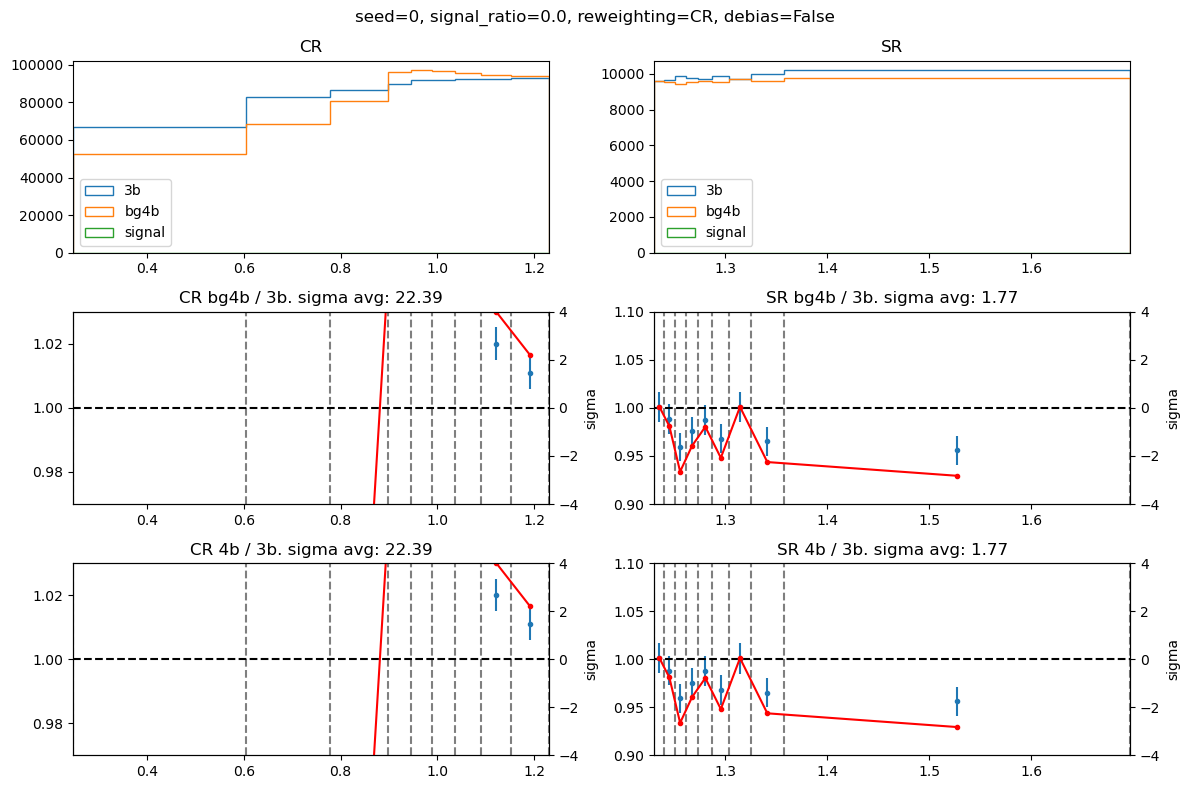

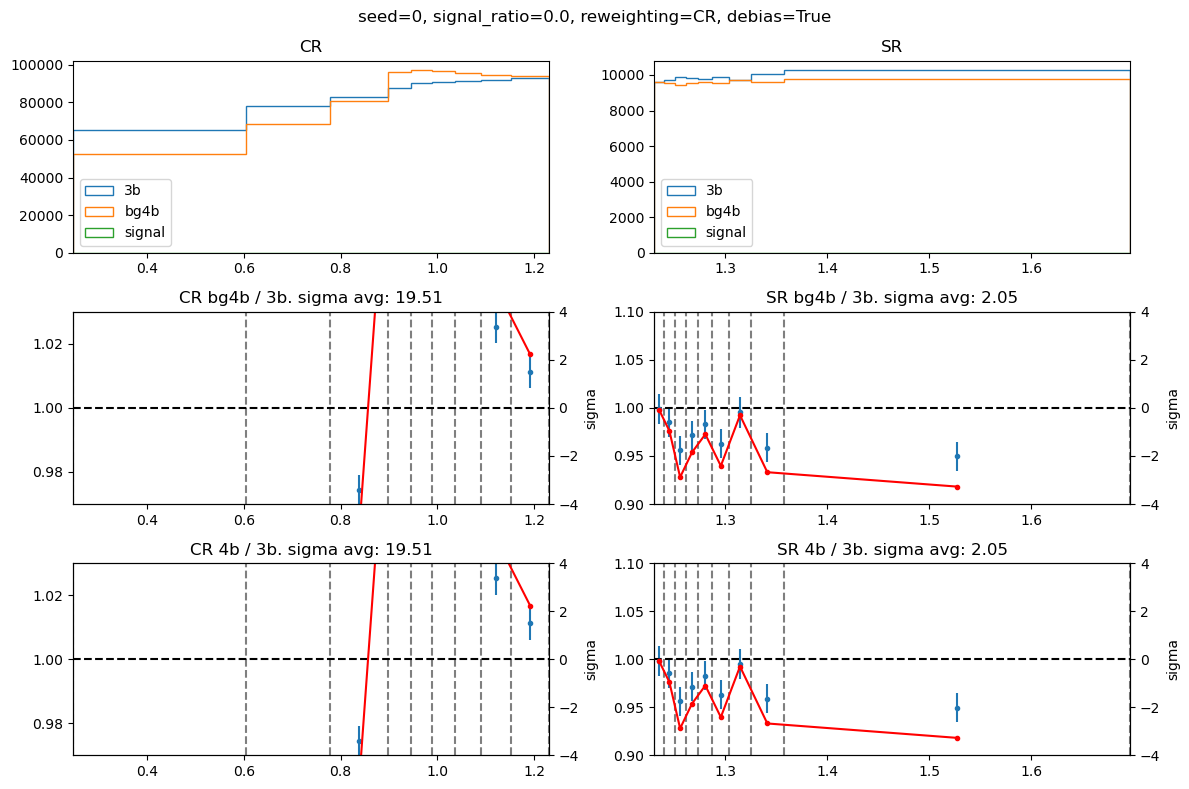

 50%|█████     | 1/2 [00:23<00:23, 23.57s/it]

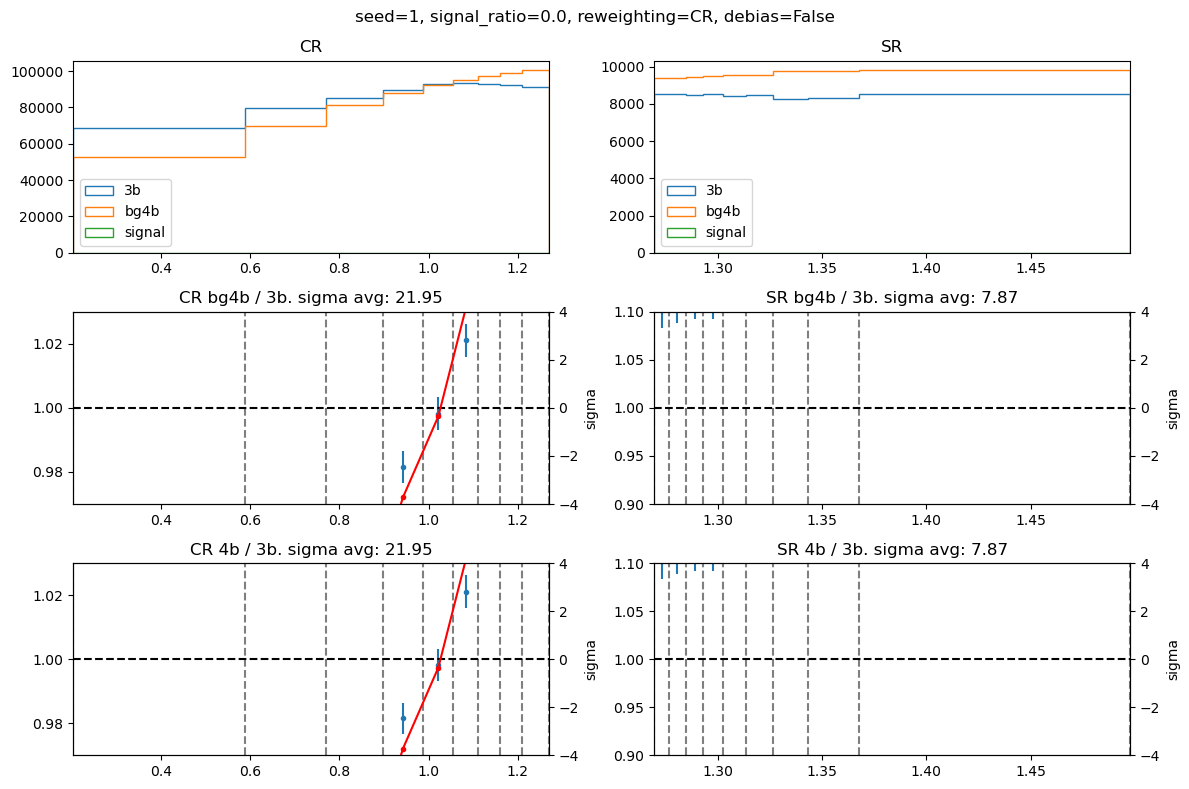

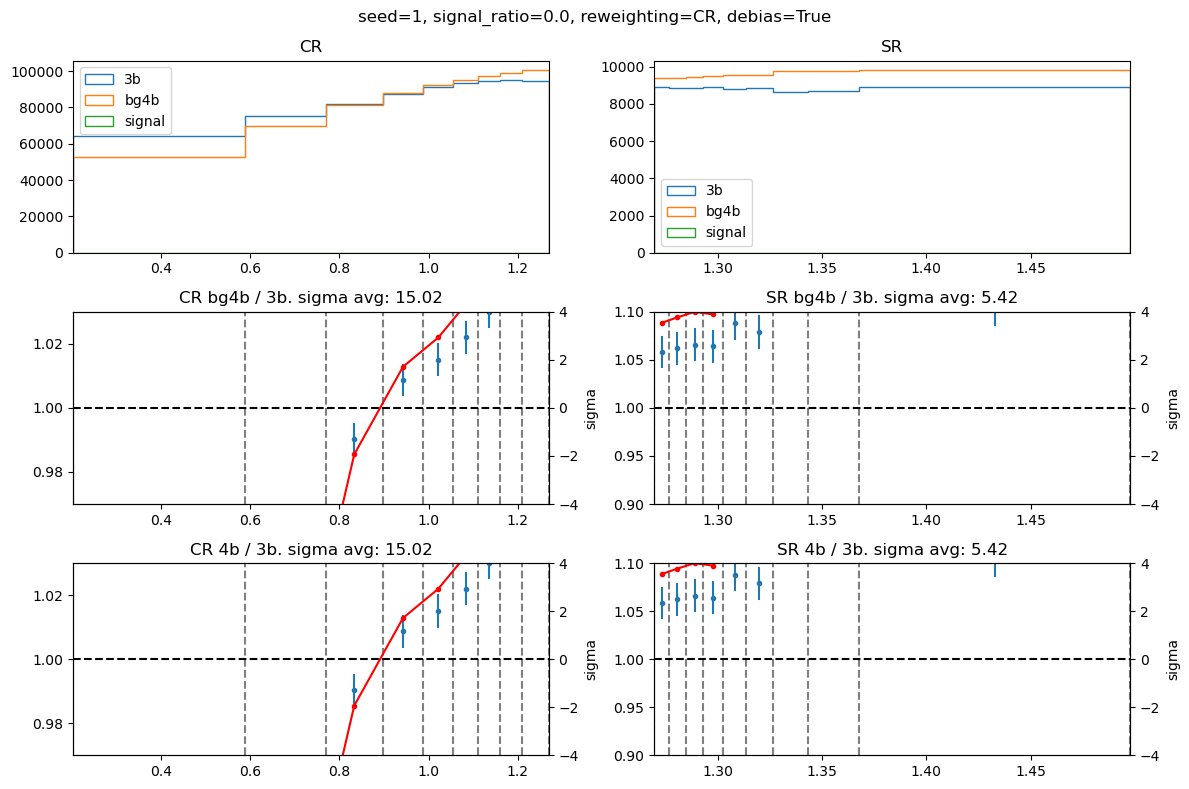

100%|██████████| 2/2 [00:47<00:00, 23.66s/it]


In [11]:
import matplotlib.pyplot as plt
from tst_info import TSTInfo


plt.rcParams["lines.markersize"] = 3

n_3b = 140_0000
device = torch.device("cuda")
do_tqdm = True
calibration_nbin = 20
rw_methods = ["CR"]
debias_list = [False, True]
experiment_name = "counting_test_freeze_encoder"

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "signal_ratio": 0.0,
    "seed": lambda x: x in [0, 1],
}

hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])
draw_routine(hashes, rw_methods=rw_methods, debias_list=debias_list, calibration_nbin=calibration_nbin)

  0%|          | 0/6 [00:00<?, ?it/s]

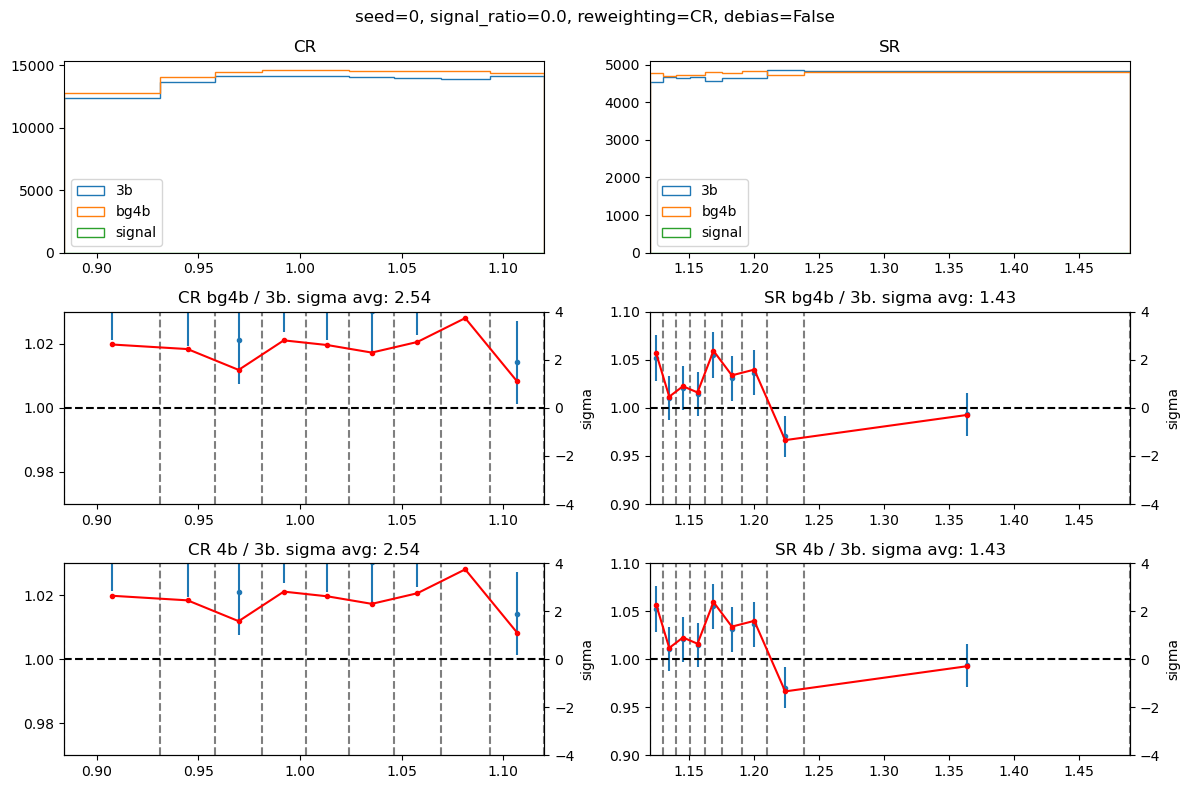

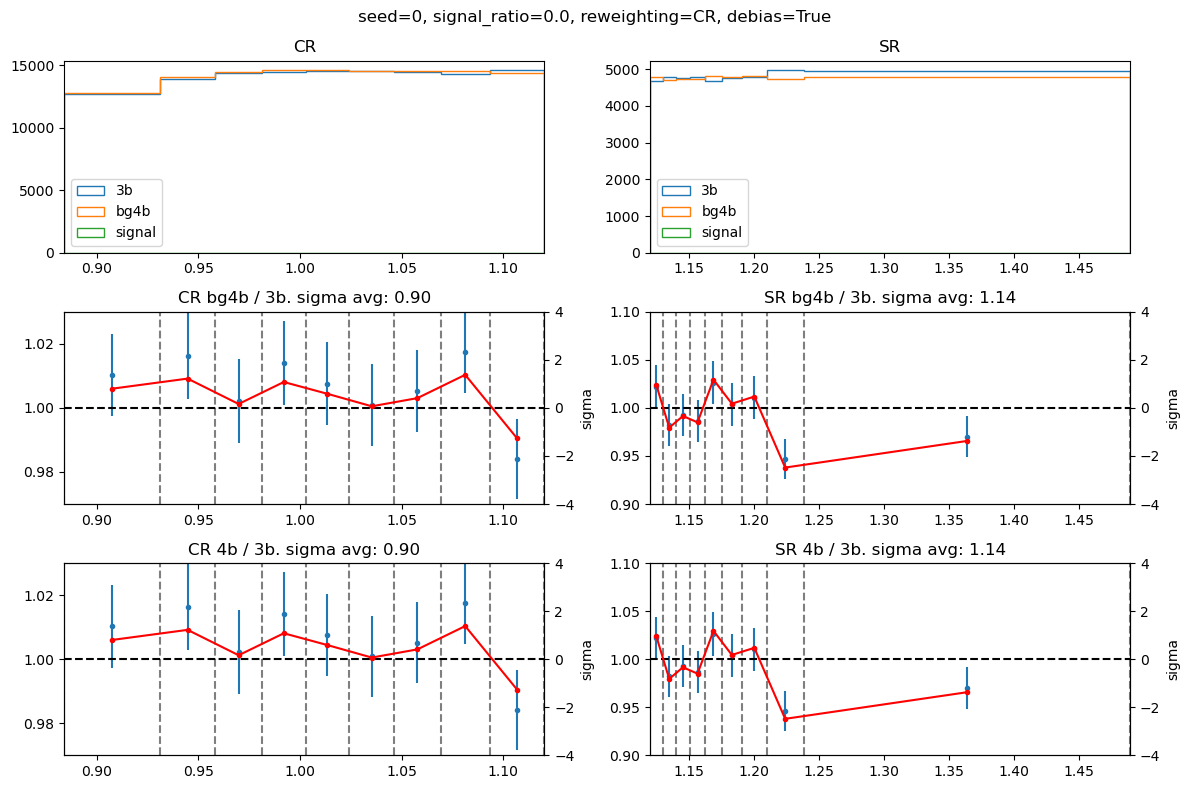

 17%|█▋        | 1/6 [00:07<00:39,  7.98s/it]

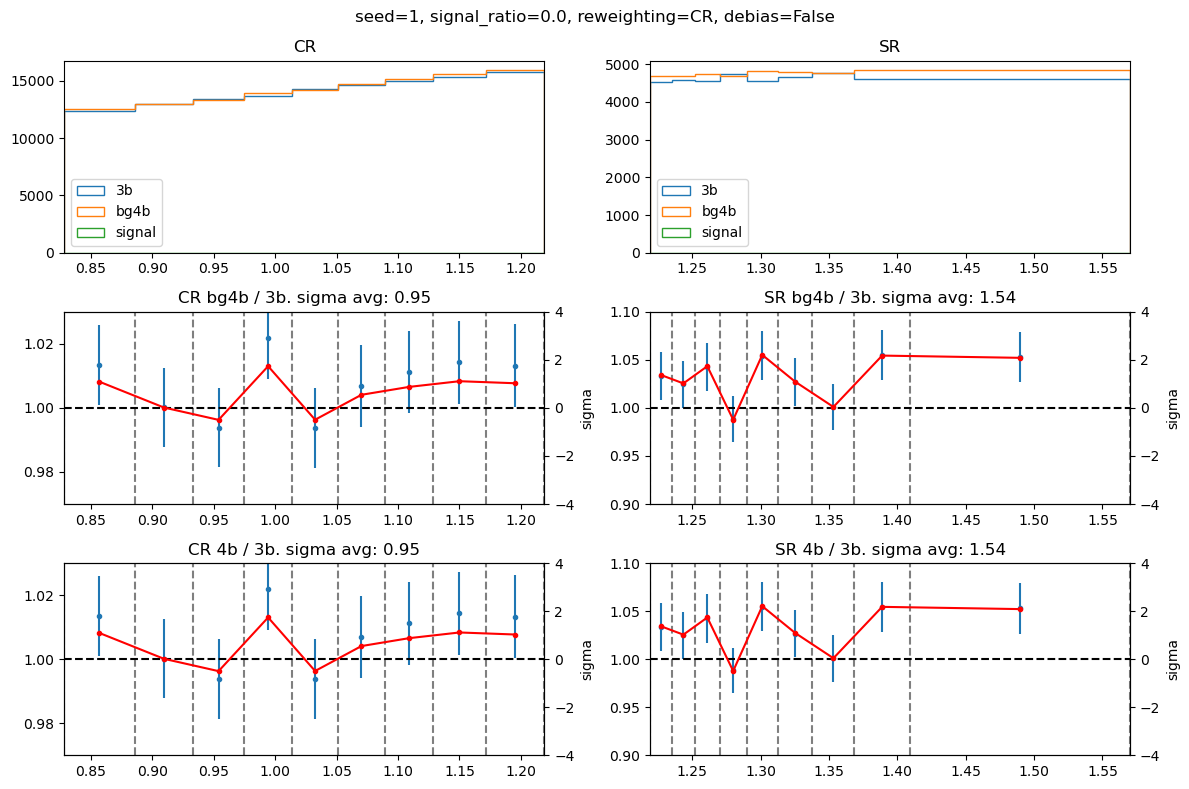

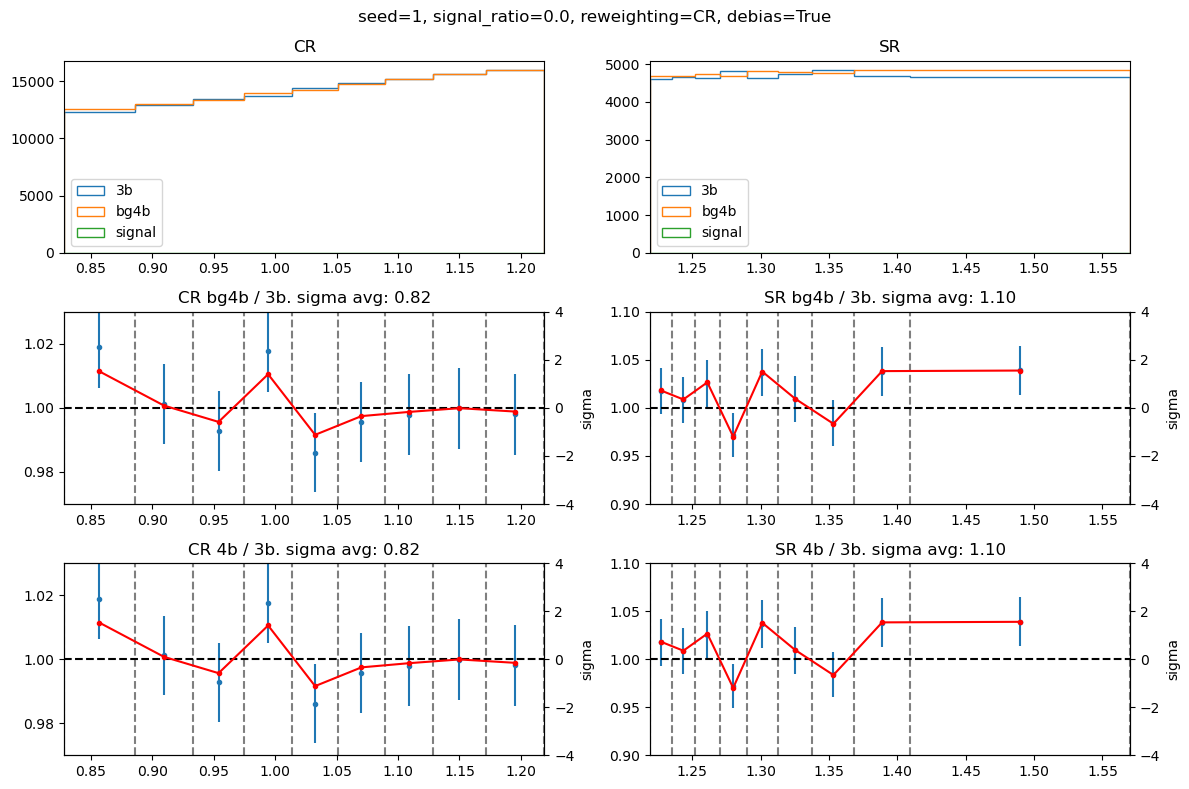

 33%|███▎      | 2/6 [00:16<00:33,  8.26s/it]

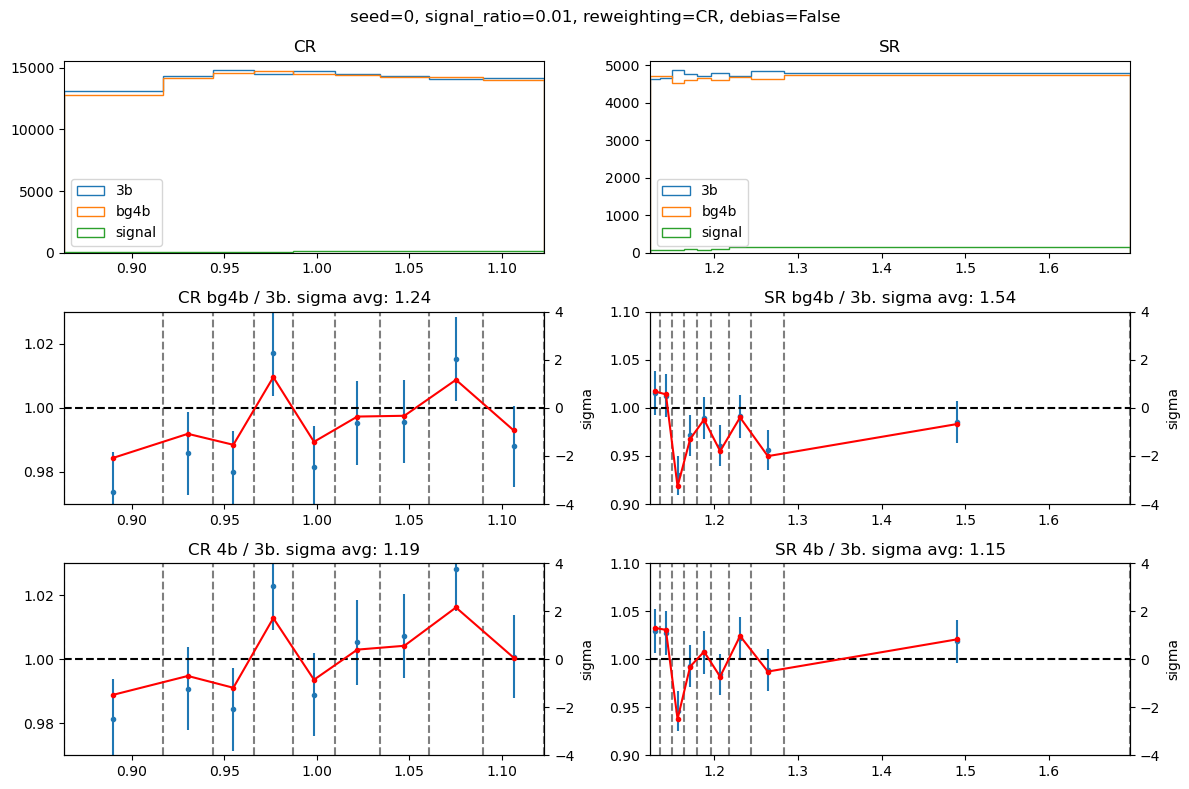

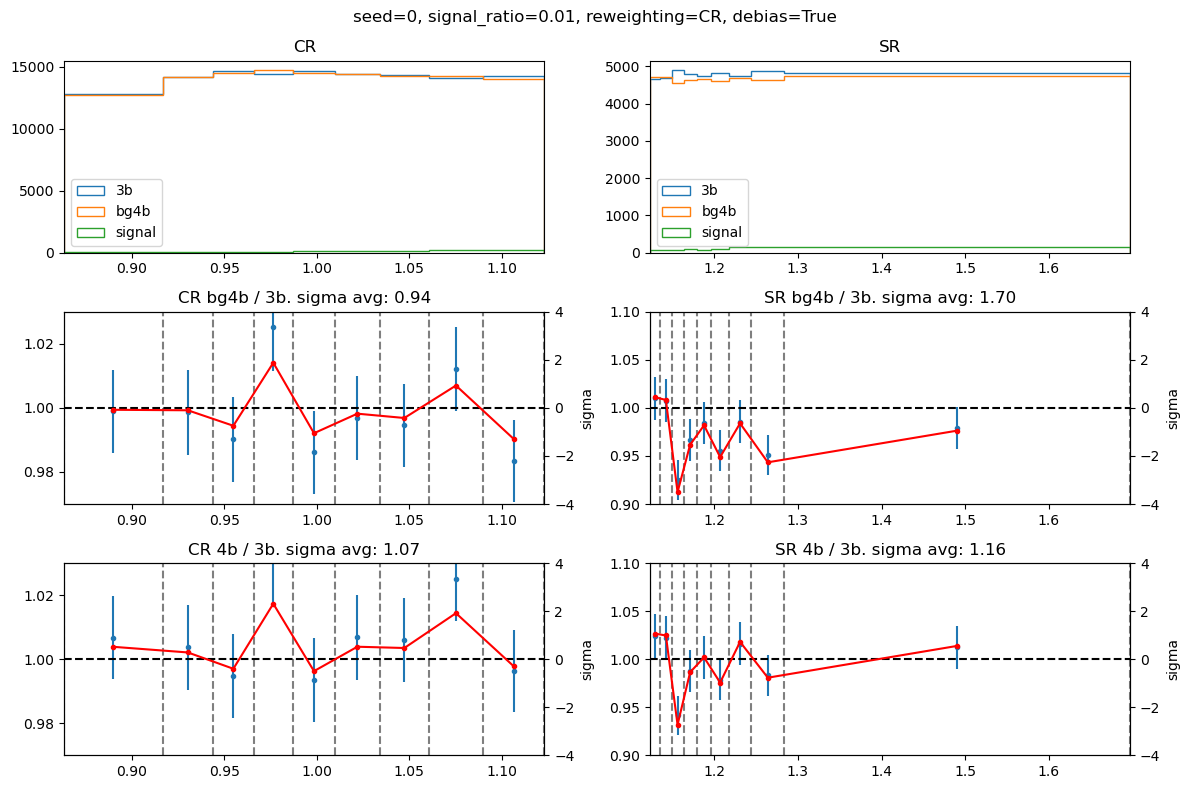

 50%|█████     | 3/6 [00:24<00:24,  8.09s/it]

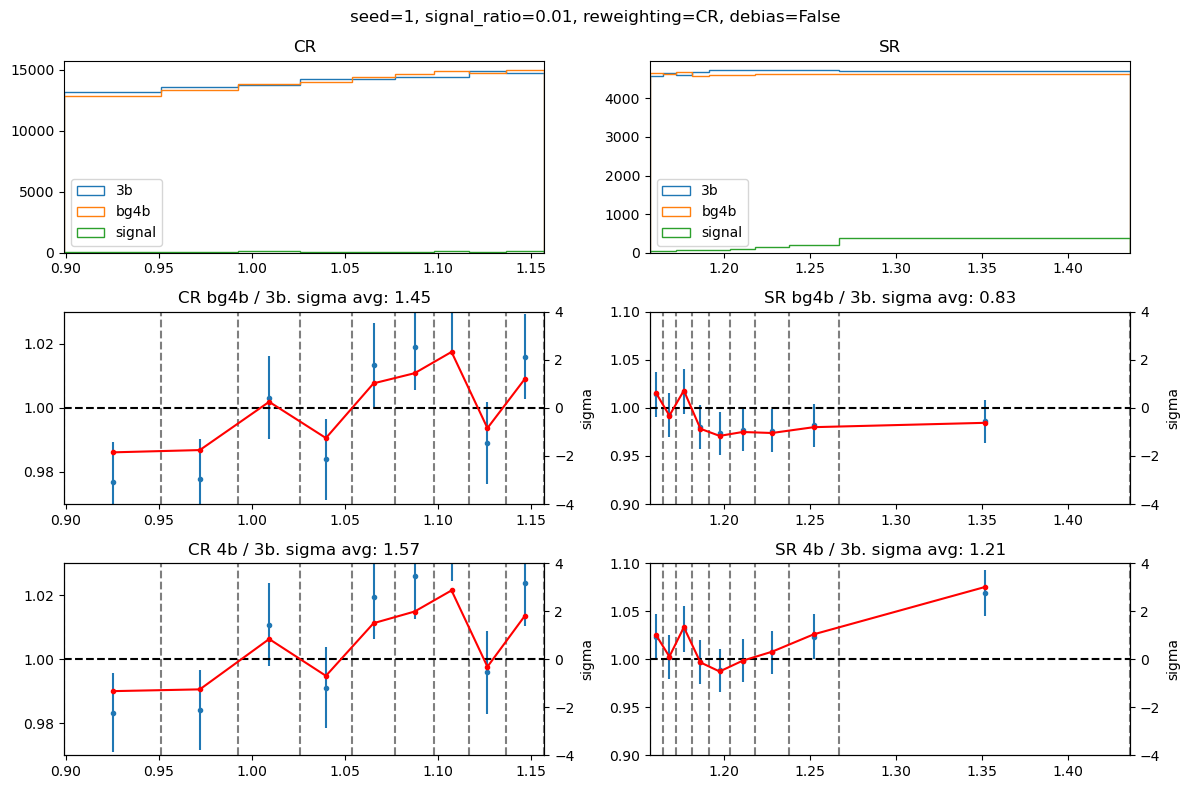

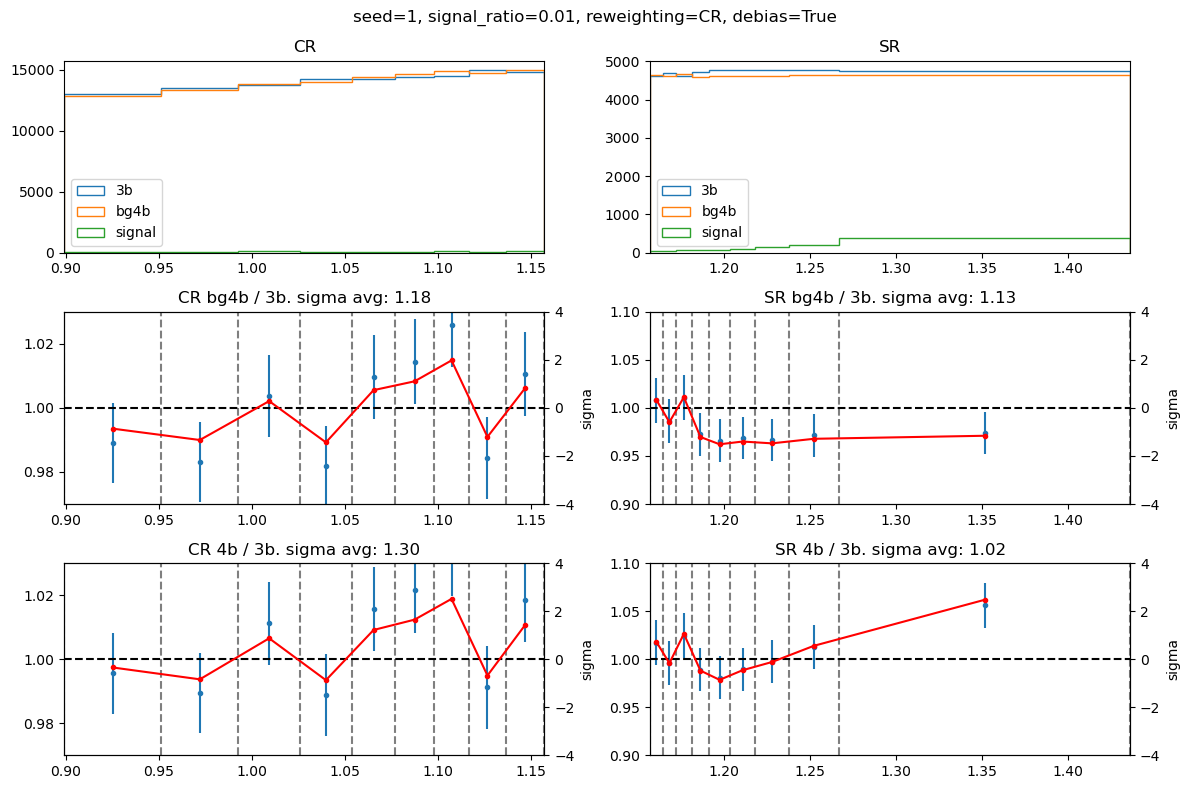

 67%|██████▋   | 4/6 [00:32<00:16,  8.02s/it]

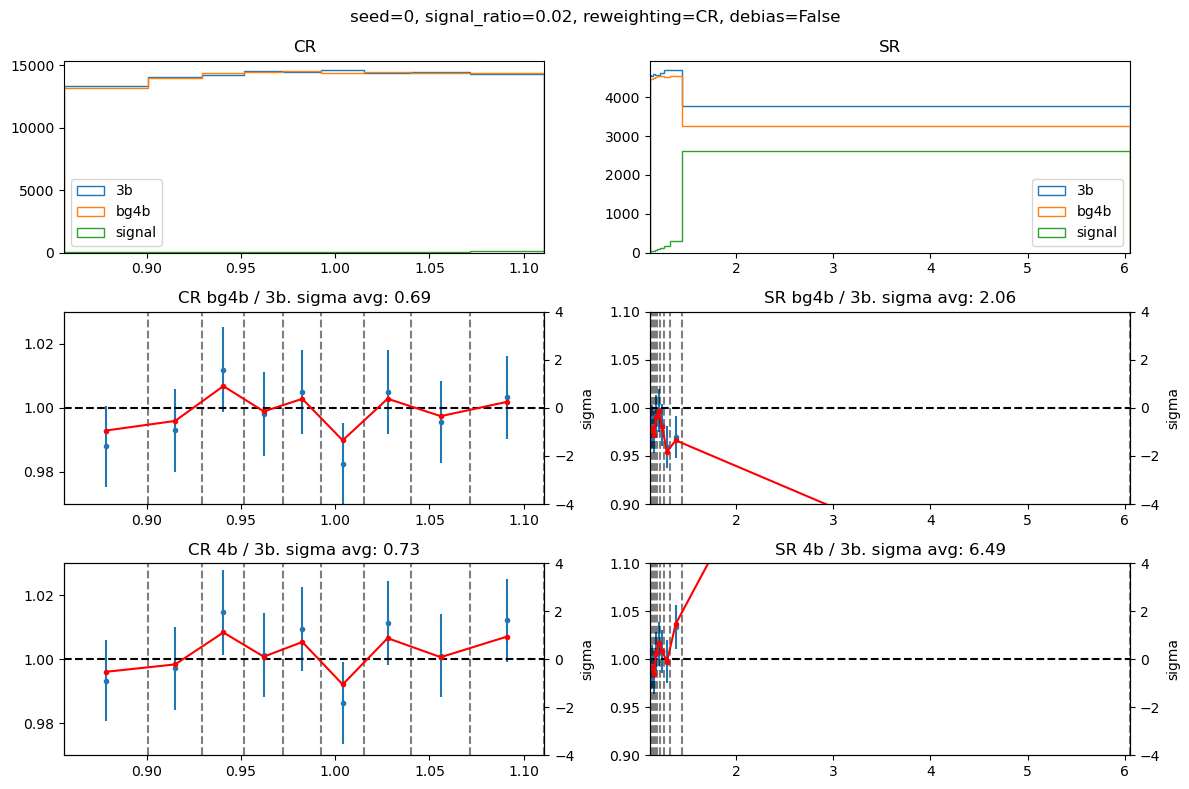

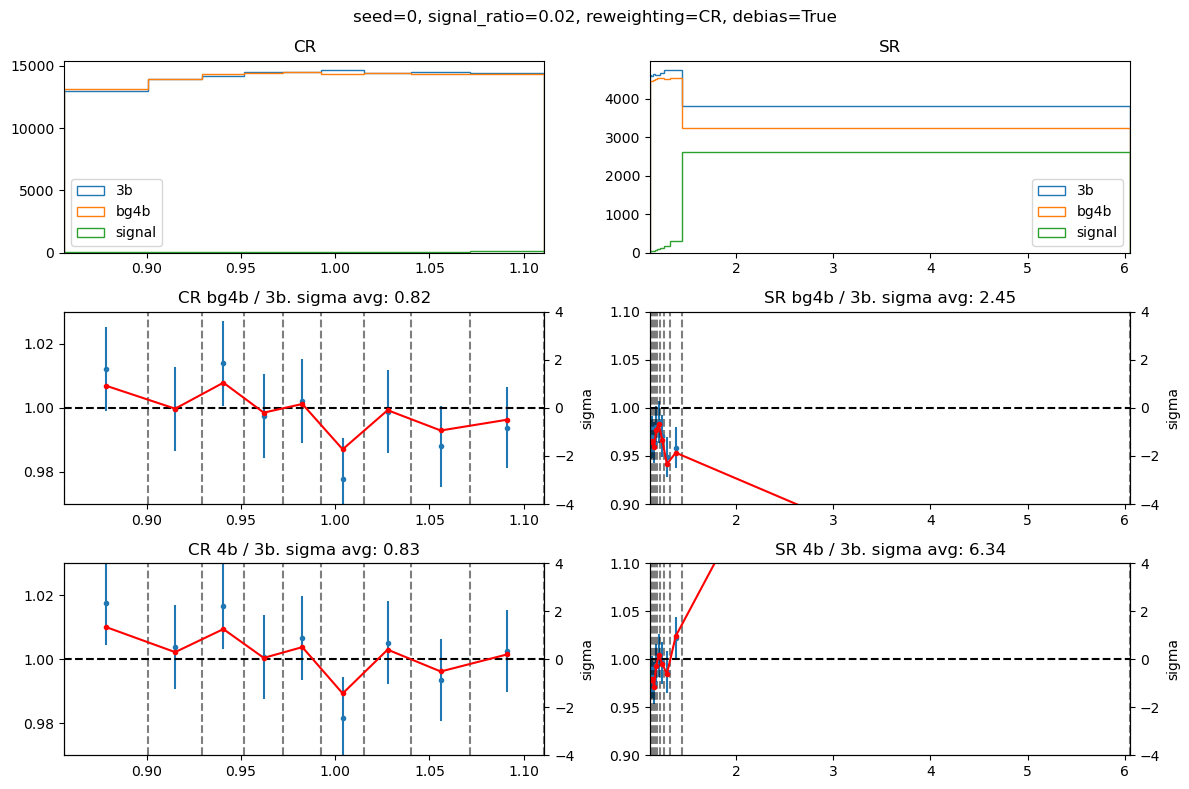

 83%|████████▎ | 5/6 [00:40<00:08,  8.09s/it]

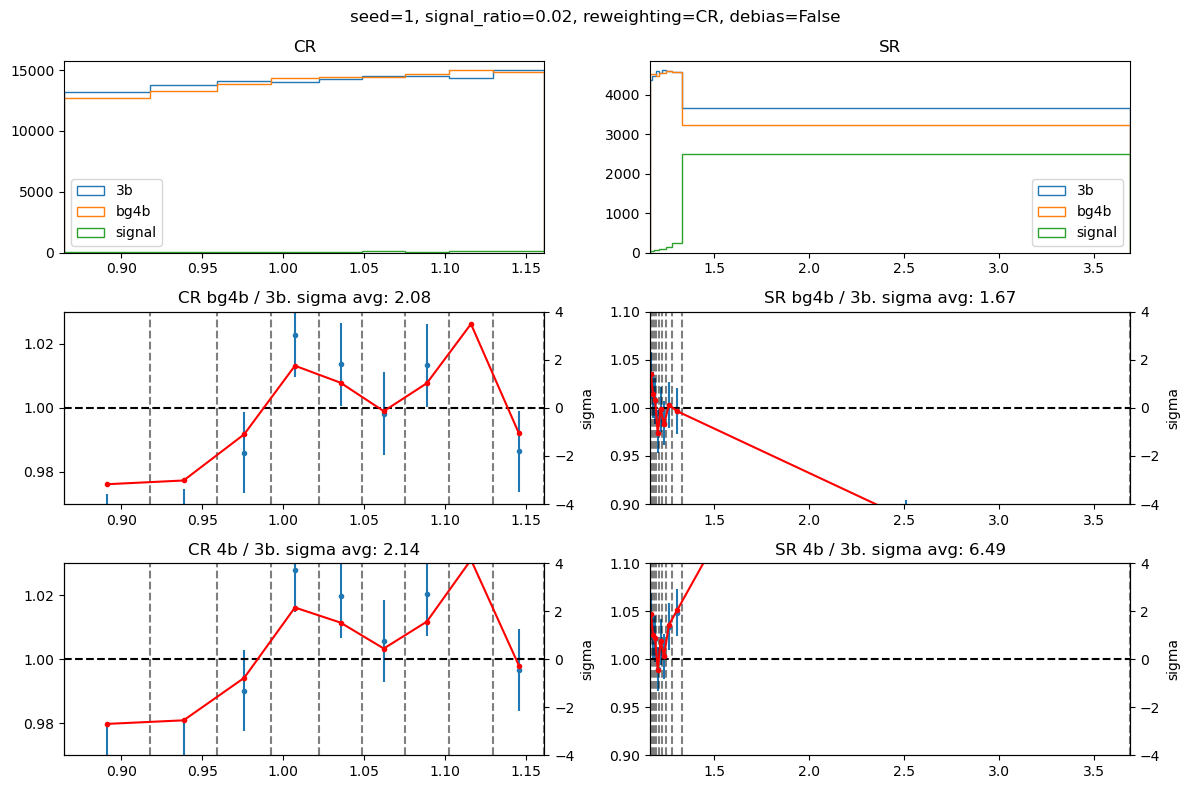

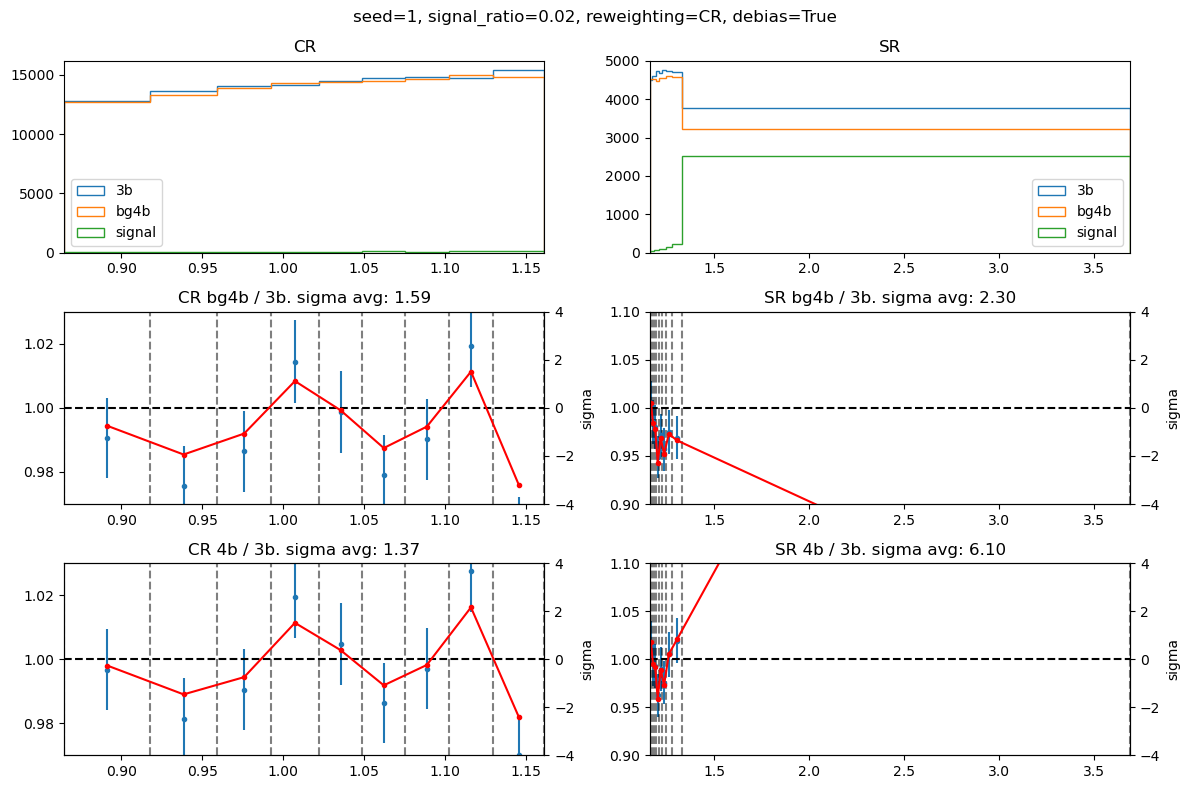

100%|██████████| 6/6 [00:48<00:00,  8.08s/it]


In [12]:
n_3b = 100_0000
device = torch.device("cuda")
do_tqdm = True
calibration_nbin = 20
rw_methods = ["CR"]
debias_list = [False, True]
experiment_name = "counting_test_v2"

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "seed": lambda x: x in [0, 1],
}

hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])
draw_routine(hashes, rw_methods=rw_methods, debias_list=debias_list, calibration_nbin=calibration_nbin)